In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12258.56it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [21]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [4]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [5]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [6]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=82.3152, Policy=0.0044, Value=164.7750
[PPO] Epoch 10: Loss=63.7297, Policy=0.0047, Value=127.5993
[PPO] Epoch 20: Loss=51.8842, Policy=0.0035, Value=103.9163
[PPO] Epoch 30: Loss=45.2725, Policy=-0.0062, Value=90.7109
Approx KL Learned: 0.01792990043759346
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/50 — steps: 4096


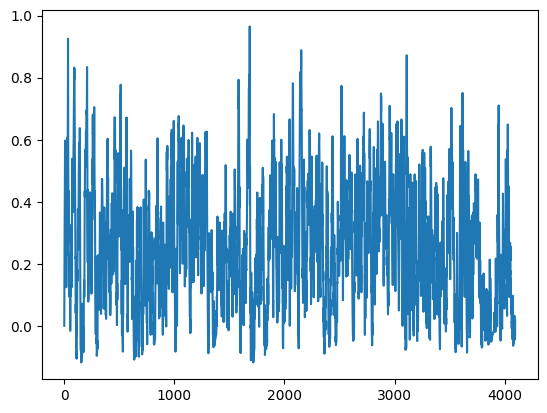

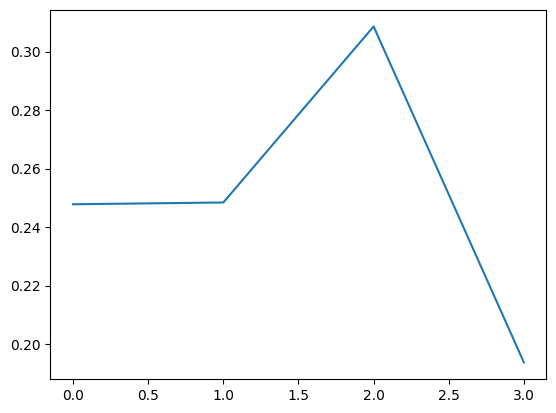

[PPO] Epoch 0: Loss=57.6022, Policy=0.0011, Value=115.3558
[PPO] Epoch 10: Loss=46.0934, Policy=-0.0029, Value=92.3451
[PPO] Epoch 20: Loss=38.7690, Policy=-0.0093, Value=77.7087
[PPO] Epoch 30: Loss=34.6297, Policy=-0.0137, Value=69.4375
Approx KL Learned: 0.011133700609207153
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/50 — steps: 4096


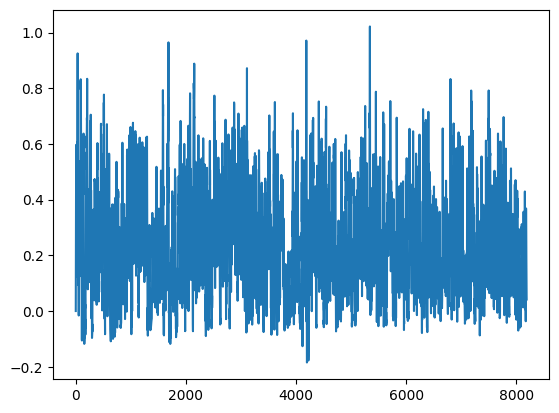

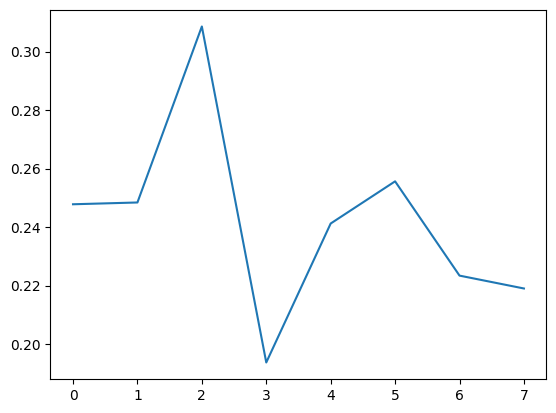

[PPO] Epoch 0: Loss=53.4566, Policy=-0.0010, Value=107.0655
[PPO] Epoch 10: Loss=46.3410, Policy=-0.0089, Value=92.8472
[PPO] Epoch 20: Loss=46.4534, Policy=-0.0127, Value=93.0790
[PPO] Epoch 30: Loss=43.0762, Policy=-0.0138, Value=86.3272
Approx KL Learned: 0.012131585739552975
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/50 — steps: 4096


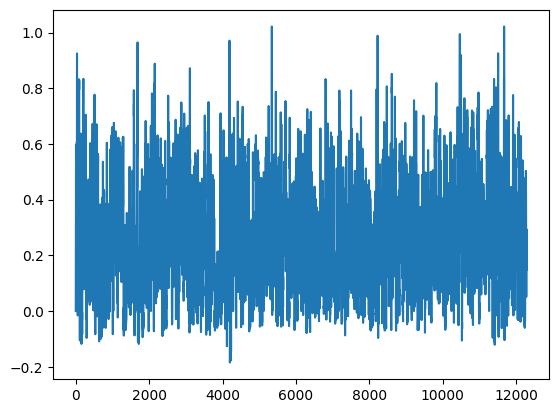

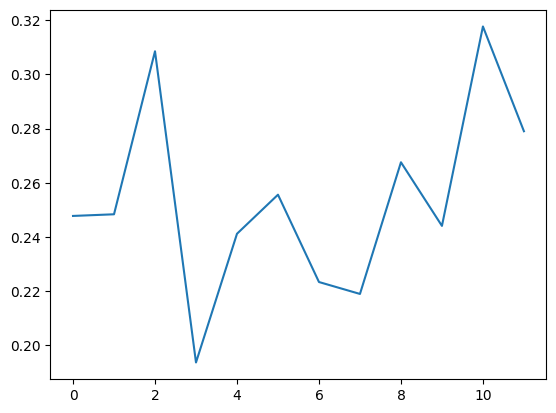

[PPO] Epoch 0: Loss=57.7579, Policy=0.0012, Value=115.6641
[PPO] Epoch 10: Loss=49.6910, Policy=0.0005, Value=99.5315
[PPO] Epoch 20: Loss=45.5747, Policy=-0.0021, Value=91.3005
[PPO] Epoch 30: Loss=40.5643, Policy=-0.0044, Value=81.2888
Approx KL Learned: 0.016144439578056335
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/50 — steps: 4096


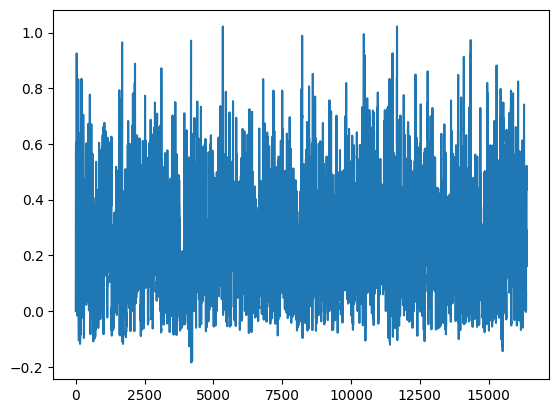

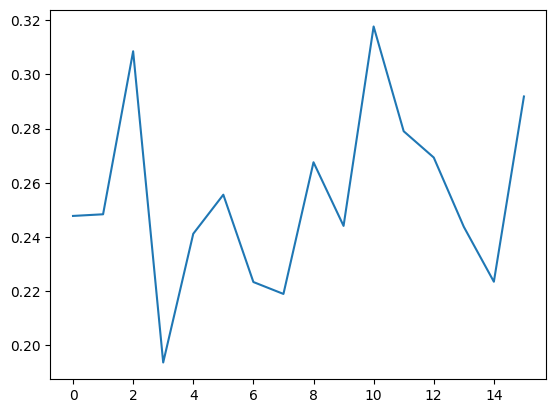

[PPO] Epoch 0: Loss=72.8388, Policy=-0.0021, Value=145.8256
[PPO] Epoch 10: Loss=56.2548, Policy=0.0138, Value=112.6327
[PPO] Epoch 20: Loss=48.3043, Policy=-0.0050, Value=96.7589
[PPO] Epoch 30: Loss=42.6416, Policy=-0.0081, Value=85.4436
Approx KL Learned: 0.015065398998558521
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/50 — steps: 4096


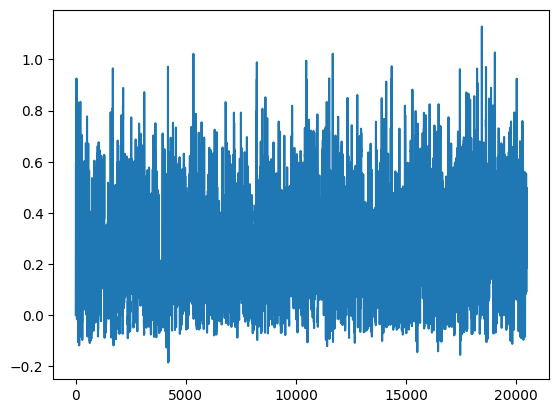

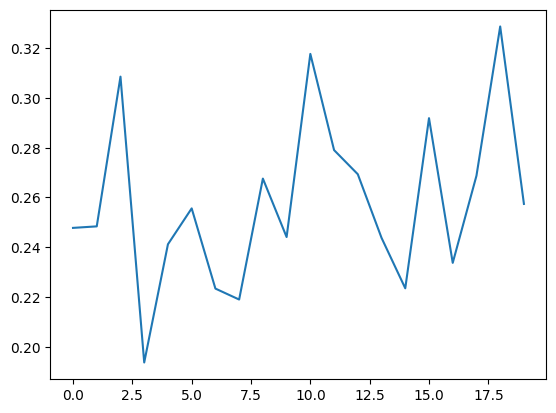

[PPO] Epoch 0: Loss=67.4594, Policy=0.0025, Value=135.0599
[PPO] Epoch 10: Loss=51.7406, Policy=-0.0026, Value=103.6292
[PPO] Epoch 20: Loss=45.0926, Policy=-0.0079, Value=90.3445
[PPO] Epoch 30: Loss=48.4051, Policy=-0.0102, Value=96.9739
Approx KL Learned: 0.013689413666725159
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/50 — steps: 4096


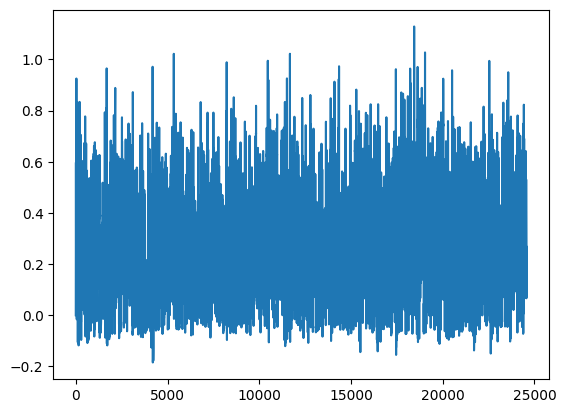

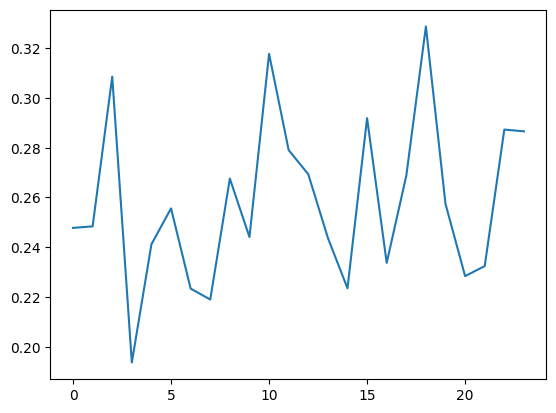

[PPO] Epoch 0: Loss=83.0943, Policy=0.0009, Value=166.3291
[PPO] Epoch 10: Loss=72.7405, Policy=-0.0015, Value=145.6235
[PPO] Epoch 20: Loss=65.9113, Policy=-0.0065, Value=131.9760
[PPO] Epoch 30: Loss=60.9396, Policy=-0.0103, Value=122.0408
Approx KL Learned: 0.013595396652817726
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/50 — steps: 4096


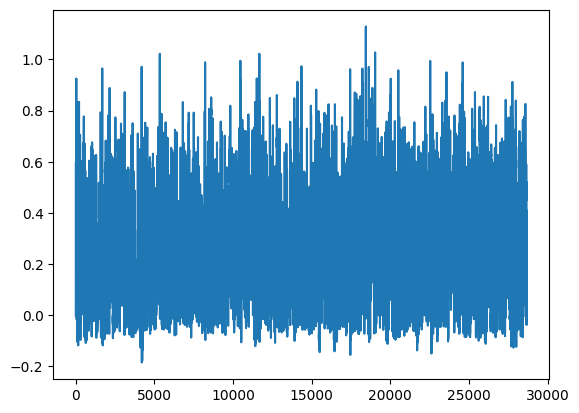

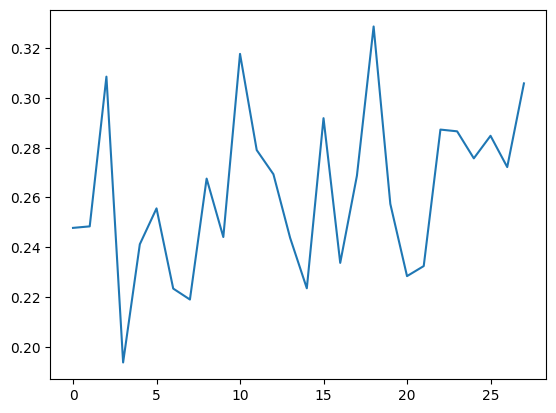

[PPO] Epoch 0: Loss=85.3844, Policy=0.0026, Value=170.9041
[PPO] Epoch 10: Loss=70.5408, Policy=-0.0015, Value=141.2221
[PPO] Epoch 20: Loss=63.0834, Policy=-0.0067, Value=126.3169
[PPO] Epoch 30: Loss=57.4101, Policy=-0.0119, Value=114.9807
Approx KL Learned: 0.01735764555633068
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/50 — steps: 4096


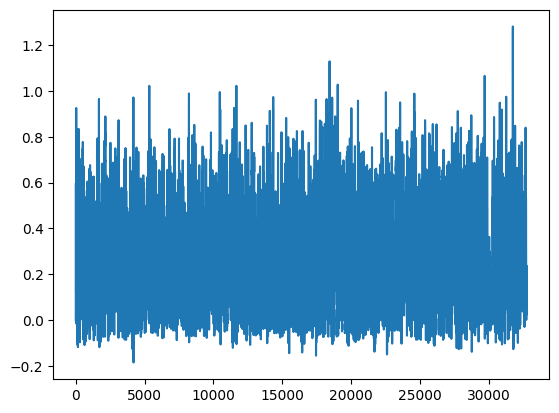

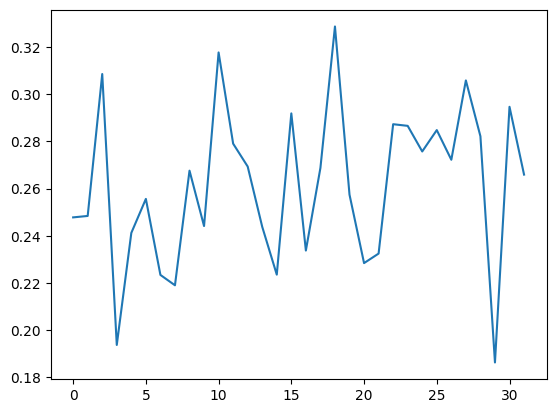

[PPO] Epoch 0: Loss=71.0349, Policy=0.0024, Value=142.1953
[PPO] Epoch 10: Loss=59.8231, Policy=-0.0028, Value=119.7839
[PPO] Epoch 20: Loss=57.7381, Policy=-0.0083, Value=115.6225
[PPO] Epoch 30: Loss=53.3038, Policy=-0.0107, Value=106.7586
Approx KL Learned: 0.027582483366131783
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/50 — steps: 4096


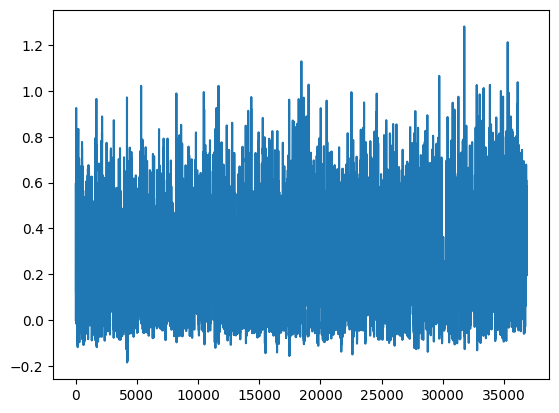

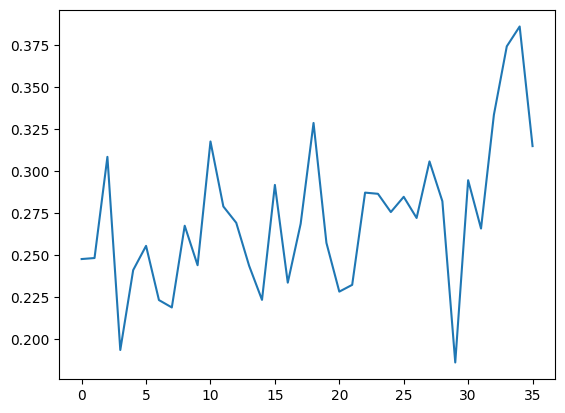

[PPO] Epoch 0: Loss=93.7283, Policy=0.0053, Value=187.5698
[PPO] Epoch 10: Loss=80.2858, Policy=0.0011, Value=160.6949
[PPO] Epoch 20: Loss=67.0956, Policy=-0.0080, Value=134.3317
[PPO] Epoch 30: Loss=59.5695, Policy=-0.0102, Value=119.2869
Approx KL Learned: 0.0184665285050869
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/50 — steps: 4096


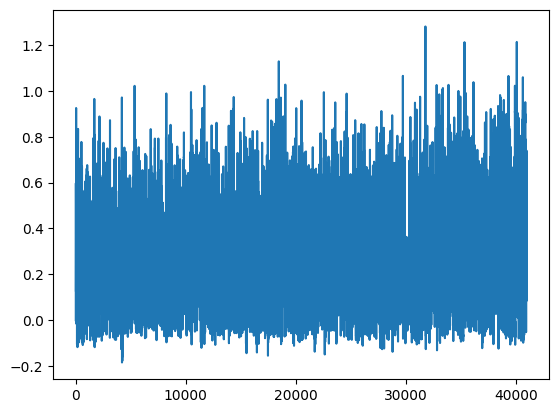

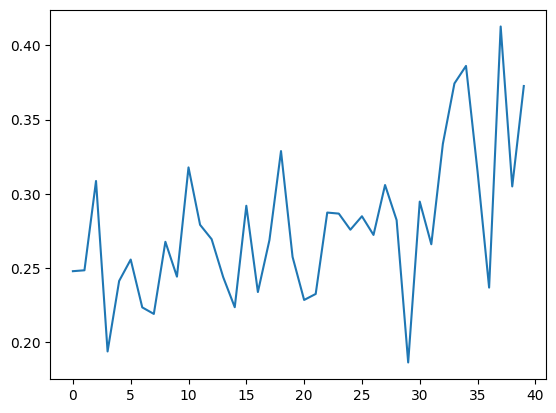

[PPO] Epoch 0: Loss=79.1852, Policy=0.0027, Value=158.4961
[PPO] Epoch 10: Loss=57.8040, Policy=-0.0049, Value=115.7445
[PPO] Epoch 20: Loss=46.6861, Policy=-0.0168, Value=93.5341
[PPO] Epoch 30: Loss=41.6286, Policy=-0.0230, Value=83.4287
Approx KL Learned: 0.04418079927563667
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 11/50 — steps: 4096


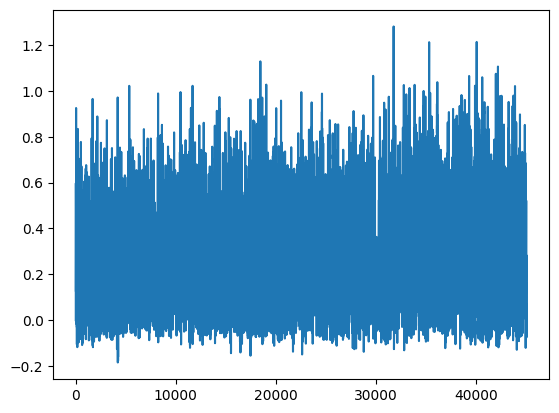

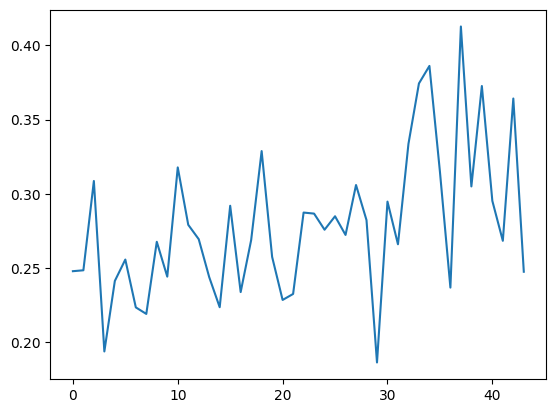

[PPO] Epoch 0: Loss=66.5777, Policy=0.0029, Value=133.2583
[PPO] Epoch 10: Loss=57.9965, Policy=0.0103, Value=116.0700
[PPO] Epoch 20: Loss=50.8168, Policy=0.0286, Value=101.6950
[PPO] Epoch 30: Loss=45.7994, Policy=0.0404, Value=91.6234
Approx KL Learned: 0.028000719845294952
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 12/50 — steps: 4096


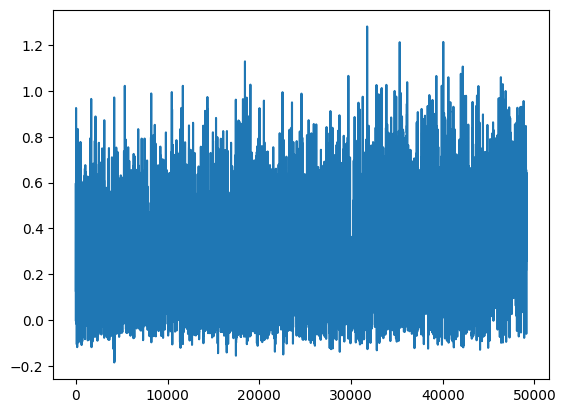

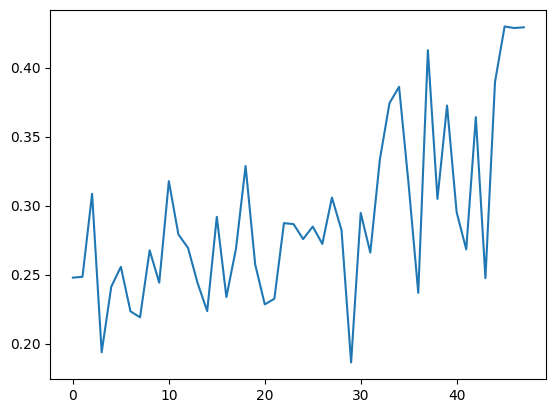

[PPO] Epoch 0: Loss=67.3007, Policy=0.0000, Value=134.7093
[PPO] Epoch 10: Loss=53.1294, Policy=0.0147, Value=106.3441
[PPO] Epoch 20: Loss=44.8586, Policy=-0.0037, Value=89.8307
[PPO] Epoch 30: Loss=38.8903, Policy=-0.0063, Value=77.9061
Approx KL Learned: 0.0078712347894907
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 13/50 — steps: 4096


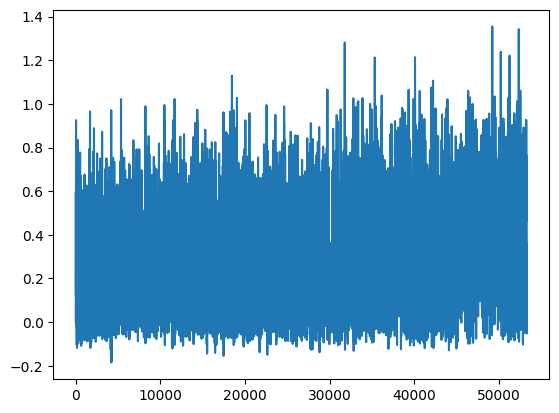

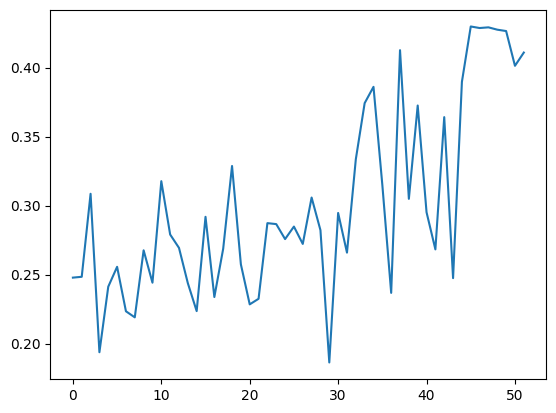

[PPO] Epoch 0: Loss=65.8072, Policy=0.0003, Value=131.7222
[PPO] Epoch 10: Loss=57.1927, Policy=0.0024, Value=114.4942
[PPO] Epoch 20: Loss=51.6936, Policy=-0.0010, Value=103.5016
[PPO] Epoch 30: Loss=43.1304, Policy=-0.0035, Value=86.3789
Approx KL Learned: 0.011409139260649681
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 14/50 — steps: 4096


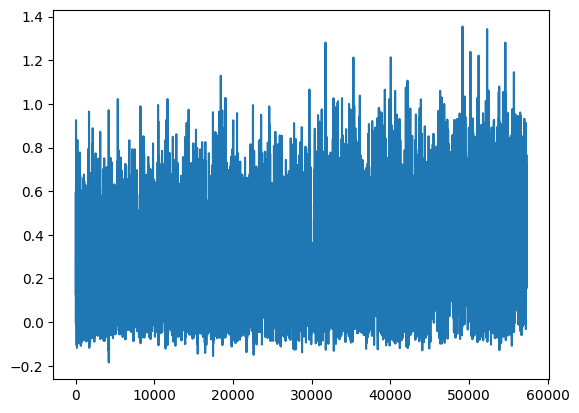

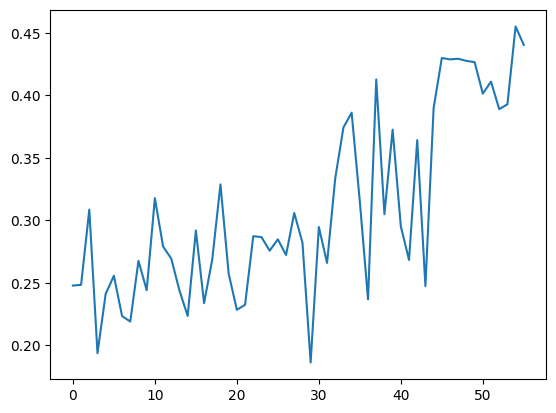

[PPO] Epoch 0: Loss=76.5912, Policy=0.0036, Value=153.2872
[PPO] Epoch 10: Loss=43.2041, Policy=-0.0021, Value=86.5253
[PPO] Epoch 20: Loss=34.6157, Policy=-0.0098, Value=69.3636
[PPO] Epoch 30: Loss=40.2902, Policy=-0.0114, Value=80.7172
Approx KL Learned: 0.022325405851006508
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 15/50 — steps: 4096


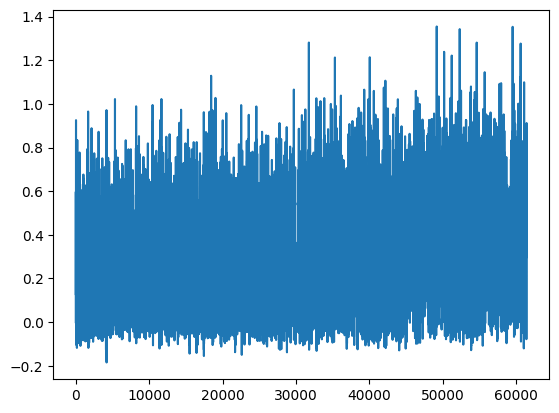

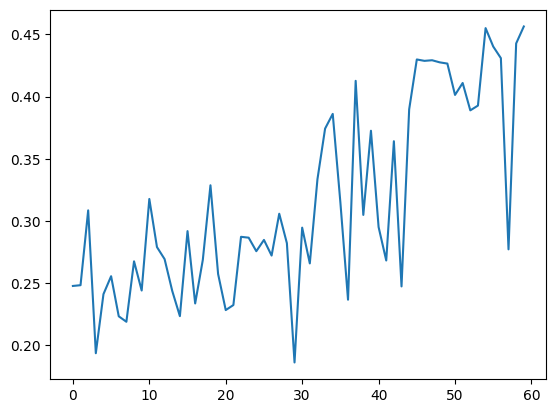

[PPO] Epoch 0: Loss=65.4527, Policy=0.0021, Value=131.0084
[PPO] Epoch 10: Loss=51.2210, Policy=-0.0013, Value=102.5545
[PPO] Epoch 20: Loss=41.6493, Policy=-0.0017, Value=83.4132
[PPO] Epoch 30: Loss=36.4966, Policy=-0.0067, Value=73.1163
Approx KL Learned: 0.019574496895074844
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 16/50 — steps: 4096


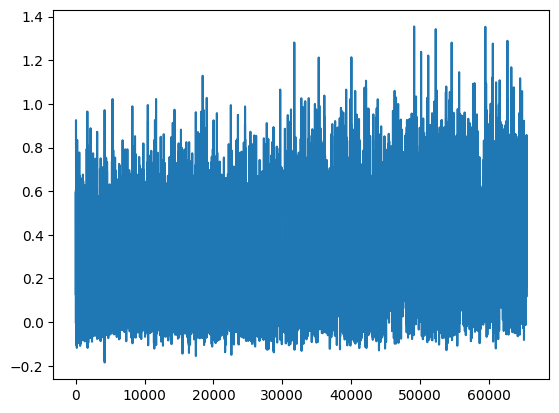

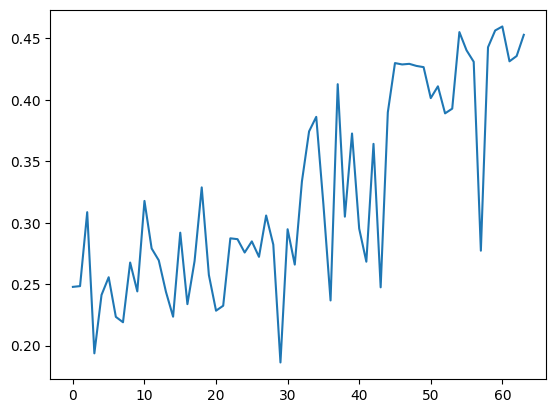

[PPO] Epoch 0: Loss=93.7290, Policy=0.0042, Value=187.5691
[PPO] Epoch 10: Loss=67.8310, Policy=0.0022, Value=135.7791
[PPO] Epoch 20: Loss=57.8890, Policy=-0.0072, Value=115.9164
[PPO] Epoch 30: Loss=51.7227, Policy=-0.0166, Value=103.6001
Approx KL Learned: 0.022984322160482407
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 17/50 — steps: 4096


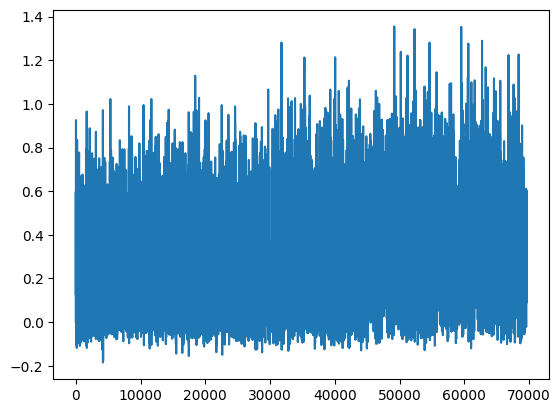

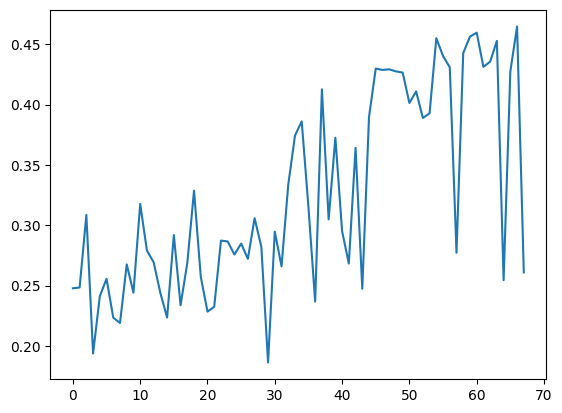

[PPO] Epoch 0: Loss=82.1527, Policy=0.0044, Value=164.4110
[PPO] Epoch 10: Loss=52.5657, Policy=-0.0032, Value=105.2514
[PPO] Epoch 20: Loss=45.1760, Policy=-0.0137, Value=90.4923
[PPO] Epoch 30: Loss=39.8734, Policy=-0.0247, Value=79.9087
Approx KL Learned: 0.03380599617958069
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 18/50 — steps: 4096


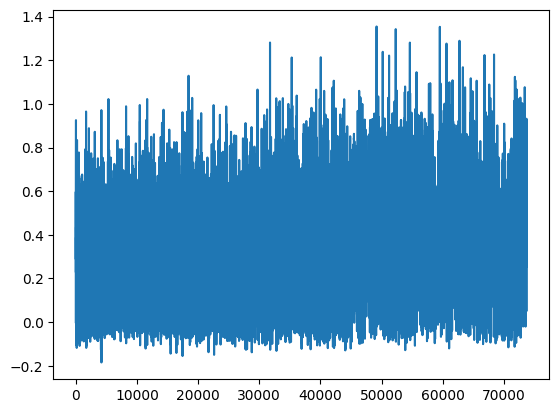

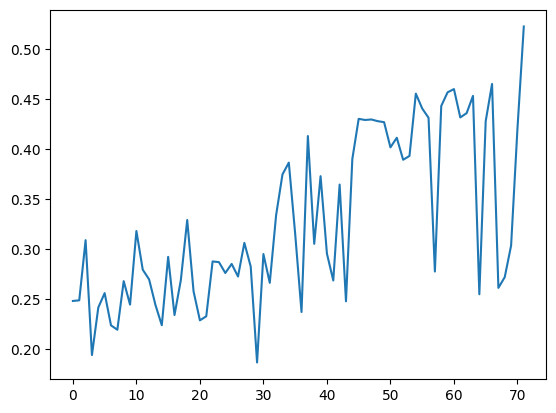

[PPO] Epoch 0: Loss=93.1338, Policy=0.0032, Value=186.3553
[PPO] Epoch 10: Loss=74.1496, Policy=0.0005, Value=148.4010
[PPO] Epoch 20: Loss=60.7771, Policy=-0.0133, Value=121.6796
[PPO] Epoch 30: Loss=52.6441, Policy=-0.0216, Value=105.4370
Approx KL Learned: 0.04743478447198868
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 19/50 — steps: 4096


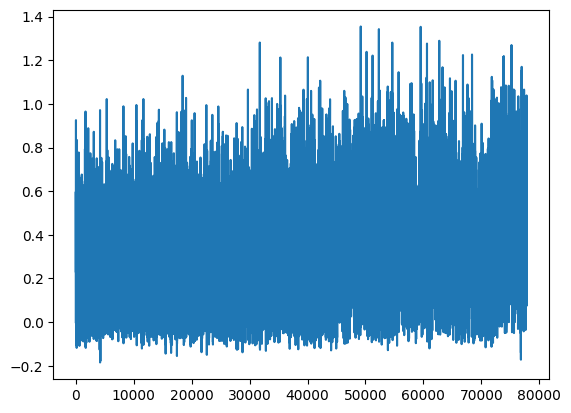

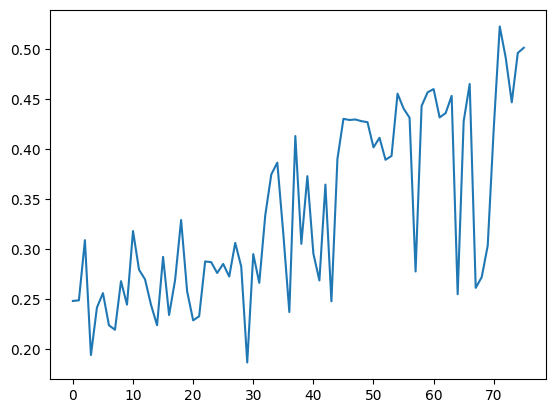

[PPO] Epoch 0: Loss=76.5763, Policy=0.0097, Value=153.2330
[PPO] Epoch 10: Loss=54.1007, Policy=-0.0001, Value=108.3031
[PPO] Epoch 20: Loss=41.4456, Policy=0.0072, Value=82.9673
[PPO] Epoch 30: Loss=35.2612, Policy=0.0430, Value=70.5433
Approx KL Learned: 0.054855771362781525
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 20/50 — steps: 4096


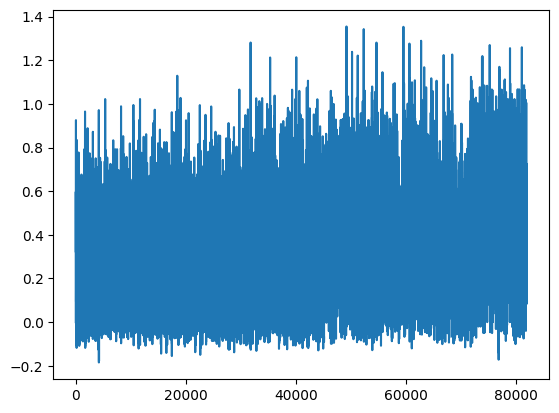

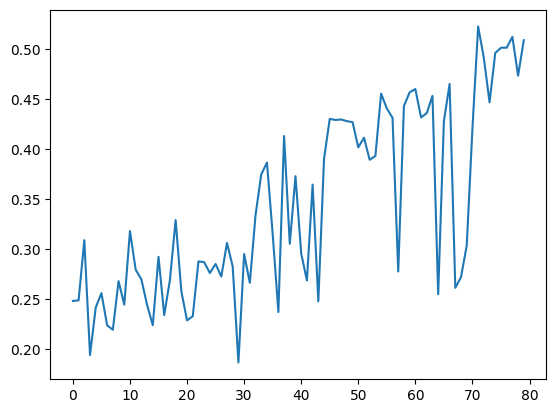

[PPO] Epoch 0: Loss=112.5637, Policy=0.0038, Value=225.2720
[PPO] Epoch 10: Loss=80.8993, Policy=0.0000, Value=161.9527
[PPO] Epoch 20: Loss=62.5664, Policy=-0.0124, Value=125.3092
[PPO] Epoch 30: Loss=54.4564, Policy=-0.0193, Value=109.1045
Approx KL Learned: 0.03237251937389374
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 21/50 — steps: 4096


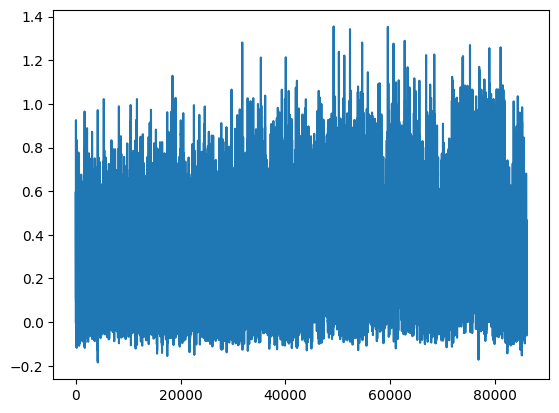

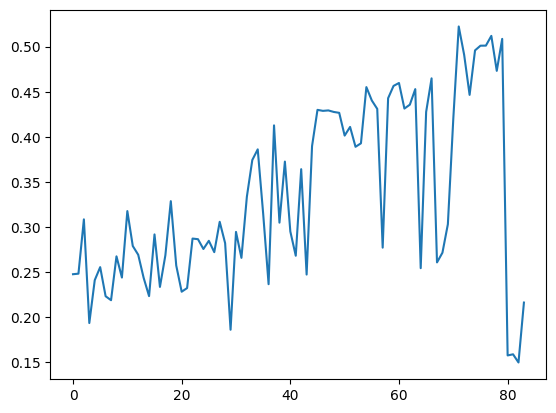

[PPO] Epoch 0: Loss=152.9573, Policy=0.0040, Value=306.0234
[PPO] Epoch 10: Loss=91.3594, Policy=0.0002, Value=182.8433
[PPO] Epoch 20: Loss=54.3135, Policy=-0.0142, Value=108.7776
[PPO] Epoch 30: Loss=43.2450, Policy=-0.0221, Value=86.6556
Approx KL Learned: 0.03869223967194557
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 22/50 — steps: 4096


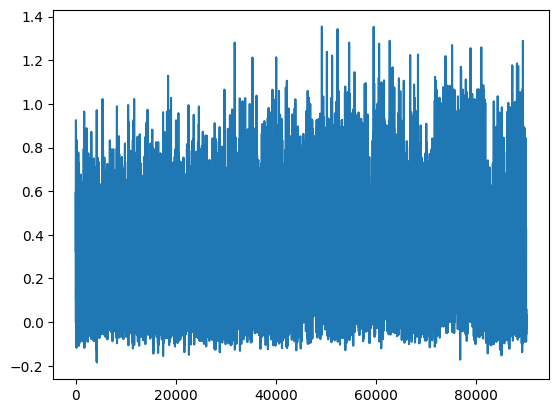

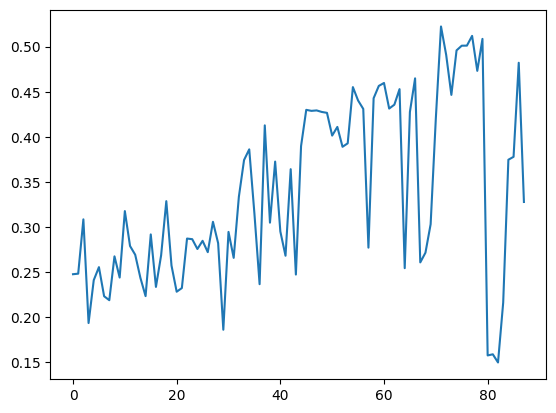

[PPO] Epoch 0: Loss=117.1203, Policy=0.0054, Value=234.3540
[PPO] Epoch 10: Loss=60.5058, Policy=-0.0078, Value=121.1493
[PPO] Epoch 20: Loss=46.6285, Policy=-0.0207, Value=93.4180
[PPO] Epoch 30: Loss=40.6386, Policy=-0.0293, Value=81.4596
Approx KL Learned: 0.04645548388361931
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 23/50 — steps: 4096


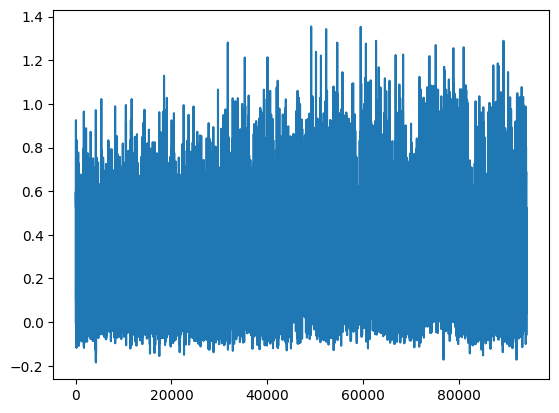

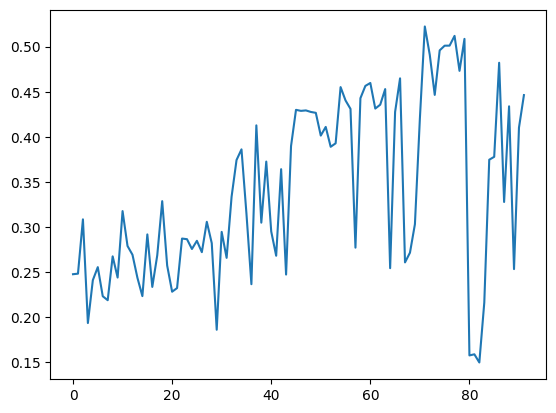

[PPO] Epoch 0: Loss=65.7304, Policy=0.0129, Value=131.5392
[PPO] Epoch 10: Loss=38.5303, Policy=-0.0036, Value=77.1702
[PPO] Epoch 20: Loss=28.3355, Policy=-0.0125, Value=56.7966
[PPO] Epoch 30: Loss=20.4378, Policy=-0.0189, Value=41.0153
Approx KL Learned: 0.03938557952642441
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 24/50 — steps: 4096


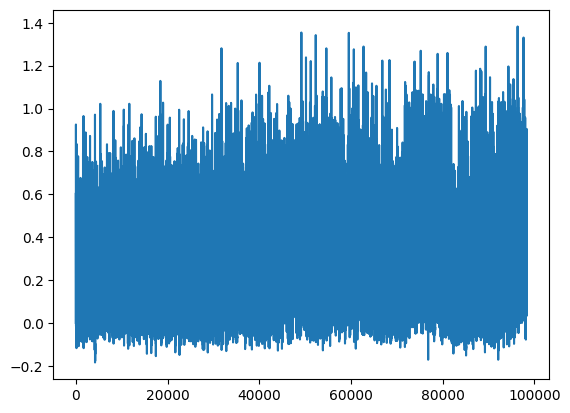

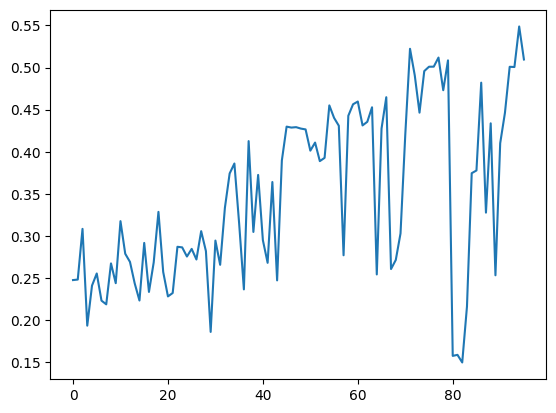

[PPO] Epoch 0: Loss=63.7345, Policy=0.0131, Value=127.5410
[PPO] Epoch 10: Loss=40.0393, Policy=-0.0055, Value=80.1816
[PPO] Epoch 20: Loss=29.1953, Policy=-0.0165, Value=58.5170
[PPO] Epoch 30: Loss=33.3617, Policy=-0.0180, Value=66.8583
Approx KL Learned: 0.2444753646850586
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 25/50 — steps: 4096


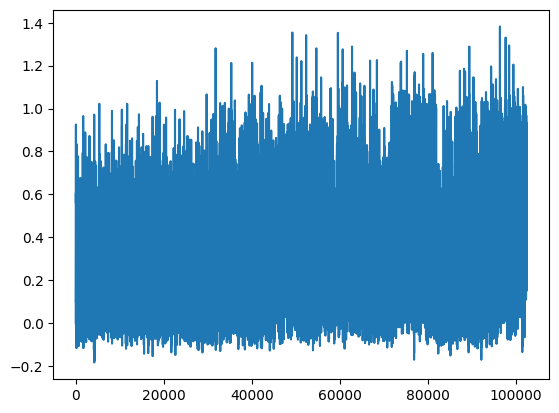

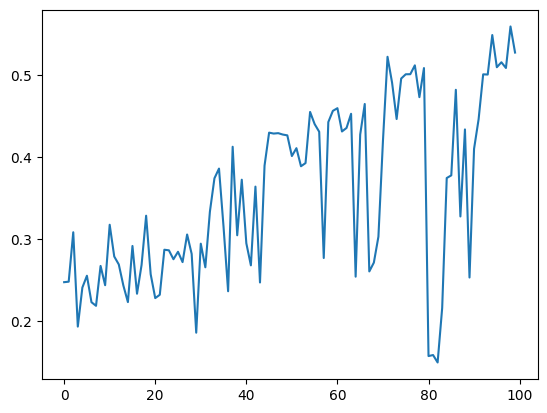

[PPO] Epoch 0: Loss=137.1002, Policy=0.0045, Value=274.3077
[PPO] Epoch 10: Loss=82.2095, Policy=-0.0026, Value=164.5515
[PPO] Epoch 20: Loss=55.7598, Policy=-0.0148, Value=111.6754
[PPO] Epoch 30: Loss=40.3143, Policy=-0.0212, Value=80.7923
Approx KL Learned: 0.045323483645915985
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 26/50 — steps: 4096


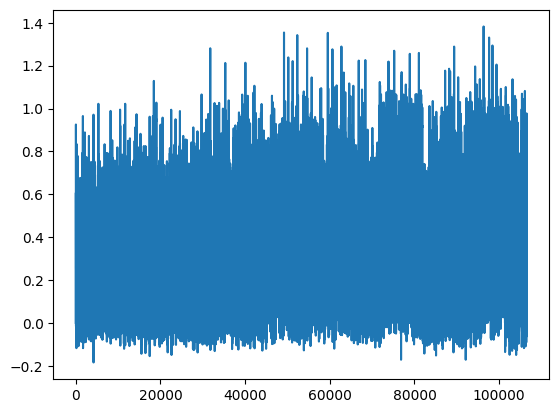

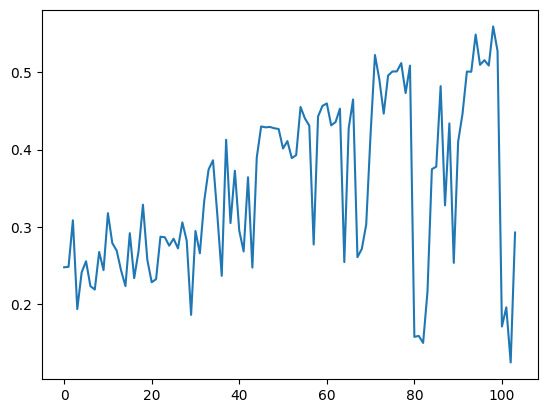

[PPO] Epoch 0: Loss=128.1537, Policy=0.0053, Value=256.4144
[PPO] Epoch 10: Loss=69.2252, Policy=-0.0044, Value=138.5771
[PPO] Epoch 20: Loss=44.5995, Policy=-0.0129, Value=89.3482
[PPO] Epoch 30: Loss=35.2674, Policy=-0.0212, Value=70.7001
Approx KL Learned: 0.031548306345939636
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 27/50 — steps: 4096


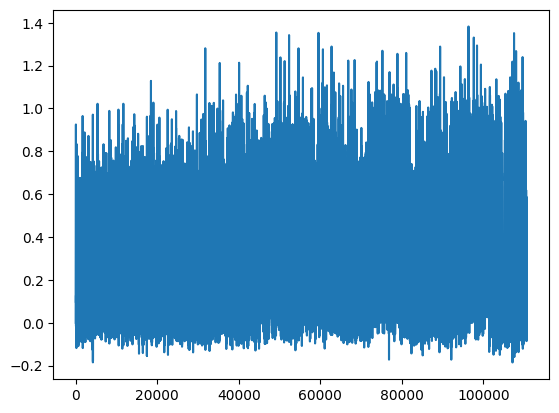

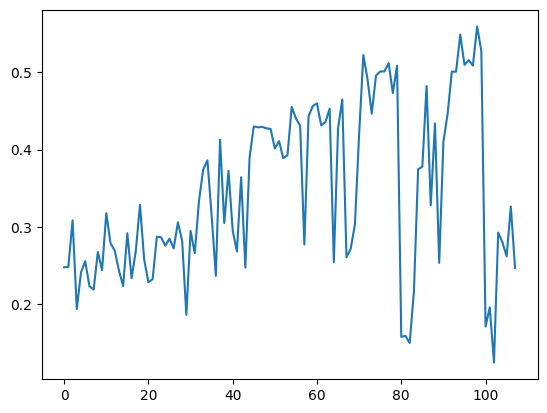

[PPO] Epoch 0: Loss=93.2121, Policy=0.0055, Value=186.5232
[PPO] Epoch 10: Loss=58.0976, Policy=-0.0015, Value=116.3140
[PPO] Epoch 20: Loss=46.3385, Policy=-0.0113, Value=92.8148
[PPO] Epoch 30: Loss=34.6501, Policy=-0.0200, Value=69.4540
Approx KL Learned: 0.032997142523527145
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 28/50 — steps: 4096


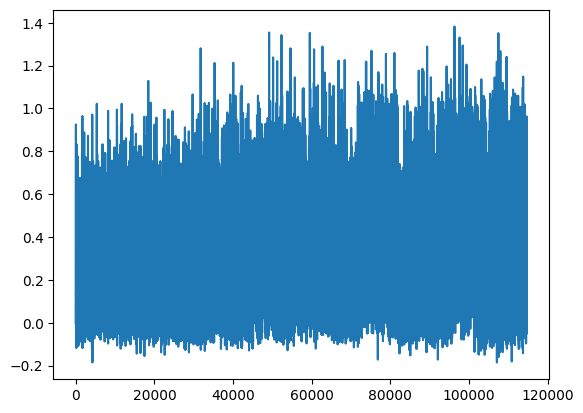

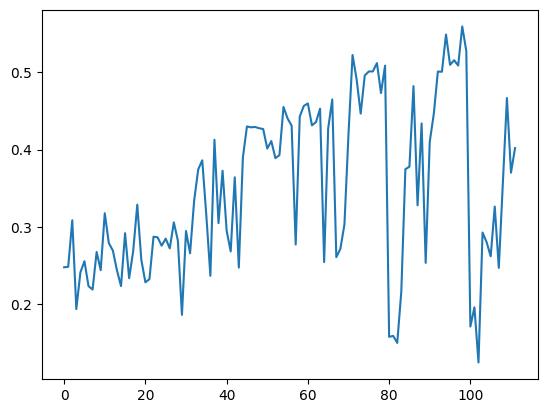

[PPO] Epoch 0: Loss=104.6434, Policy=0.0083, Value=209.3885
[PPO] Epoch 10: Loss=78.4598, Policy=0.0047, Value=157.0309
[PPO] Epoch 20: Loss=62.6313, Policy=-0.0067, Value=125.3958
[PPO] Epoch 30: Loss=56.4003, Policy=-0.0141, Value=112.9464
Approx KL Learned: 0.02764119580388069
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 29/50 — steps: 4096


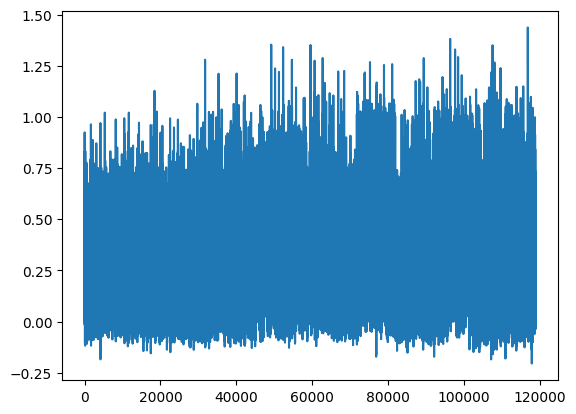

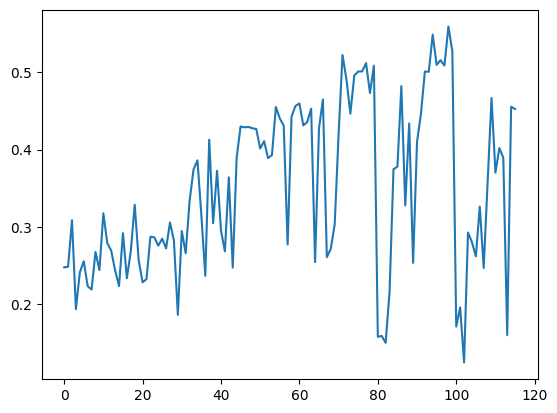

[PPO] Epoch 0: Loss=88.0972, Policy=0.0081, Value=176.3304
[PPO] Epoch 10: Loss=52.8282, Policy=-0.0068, Value=105.8193
[PPO] Epoch 20: Loss=36.6487, Policy=-0.0171, Value=73.4797
[PPO] Epoch 30: Loss=28.1707, Policy=-0.0224, Value=56.5388
Approx KL Learned: 0.05499102175235748
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 30/50 — steps: 4096


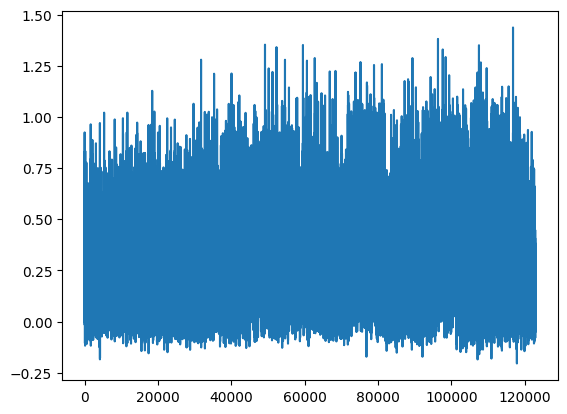

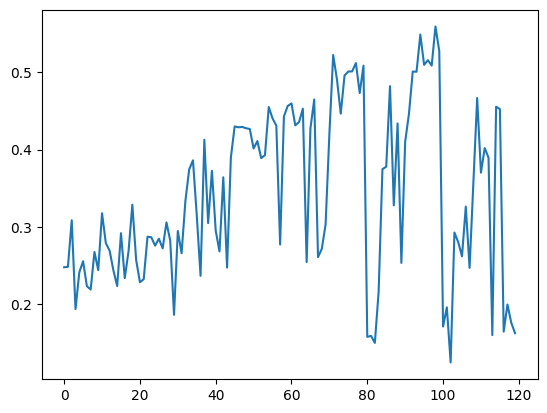

[PPO] Epoch 0: Loss=89.0418, Policy=0.0058, Value=178.2099
[PPO] Epoch 10: Loss=51.6106, Policy=-0.0025, Value=103.3646
[PPO] Epoch 20: Loss=39.6071, Policy=-0.0119, Value=79.3764
[PPO] Epoch 30: Loss=39.0891, Policy=-0.0253, Value=78.3658
Approx KL Learned: 0.02175169065594673
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 31/50 — steps: 4096


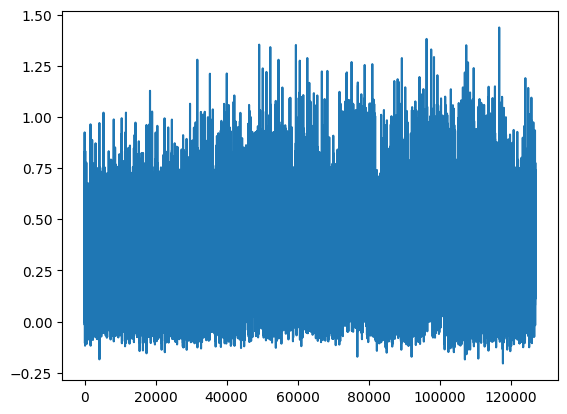

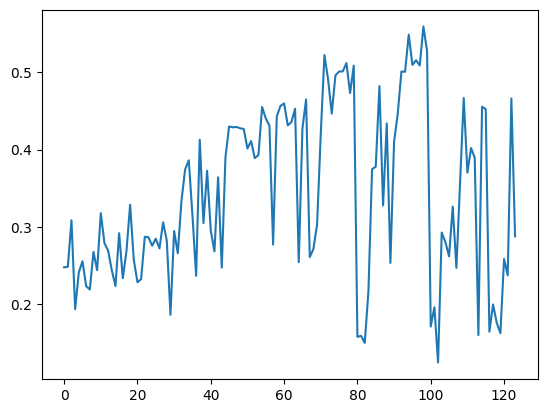

[PPO] Epoch 0: Loss=86.6224, Policy=0.0029, Value=173.3768
[PPO] Epoch 10: Loss=64.4067, Policy=-0.0045, Value=128.9600
[PPO] Epoch 20: Loss=43.6505, Policy=-0.0202, Value=87.4759
[PPO] Epoch 30: Loss=42.4686, Policy=-0.0244, Value=85.1189
Approx KL Learned: 0.020865296944975853
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 32/50 — steps: 4096


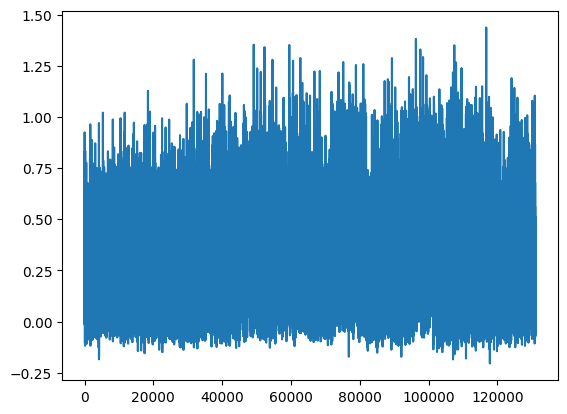

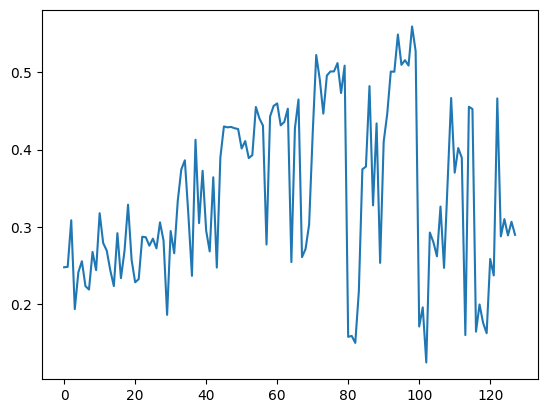

[PPO] Epoch 0: Loss=81.2193, Policy=0.0068, Value=162.5360
[PPO] Epoch 10: Loss=57.6536, Policy=-0.0009, Value=115.4237
[PPO] Epoch 20: Loss=47.6889, Policy=-0.0110, Value=95.5148
[PPO] Epoch 30: Loss=40.7349, Policy=-0.0255, Value=81.6352
Approx KL Learned: 0.03884608671069145
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 33/50 — steps: 4096


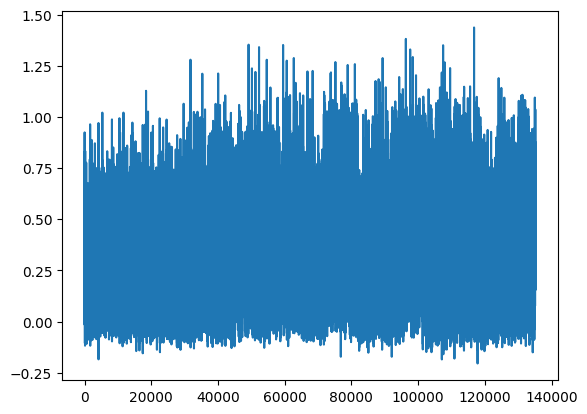

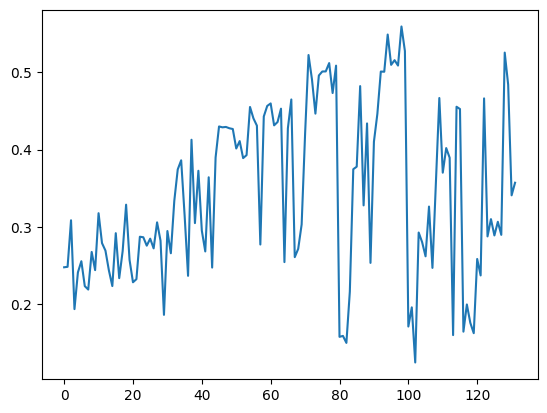

[PPO] Epoch 0: Loss=82.4956, Policy=0.0101, Value=165.0602
[PPO] Epoch 10: Loss=53.8497, Policy=0.0030, Value=107.7854
[PPO] Epoch 20: Loss=41.5637, Policy=-0.0087, Value=83.2306
[PPO] Epoch 30: Loss=34.0679, Policy=-0.0097, Value=68.2474
Approx KL Learned: 0.0531783327460289
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 34/50 — steps: 4096


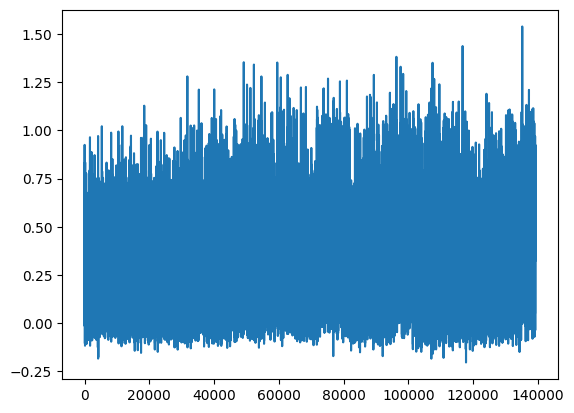

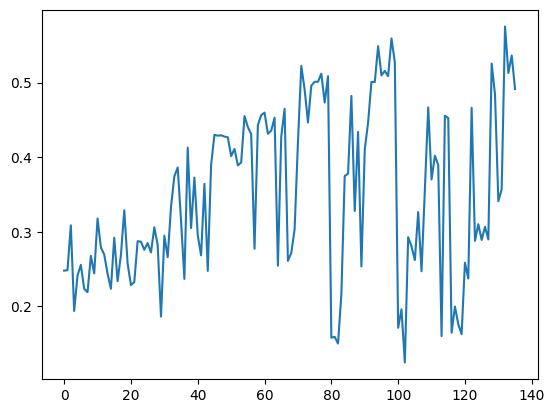

[PPO] Epoch 0: Loss=72.9488, Policy=0.0035, Value=145.9988
[PPO] Epoch 10: Loss=50.9835, Policy=0.0044, Value=102.0689
[PPO] Epoch 20: Loss=38.1342, Policy=-0.0123, Value=76.4035
[PPO] Epoch 30: Loss=32.8936, Policy=-0.0271, Value=65.9500
Approx KL Learned: 0.040498897433280945
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 35/50 — steps: 4096


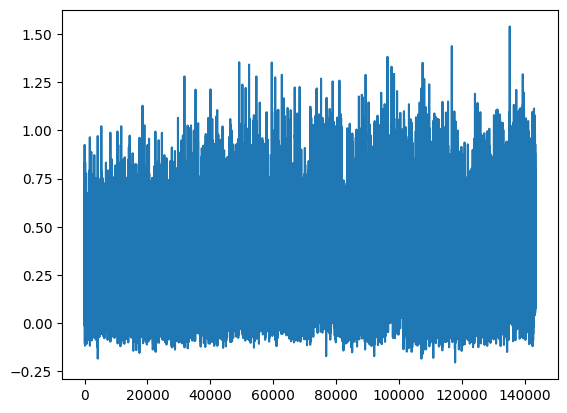

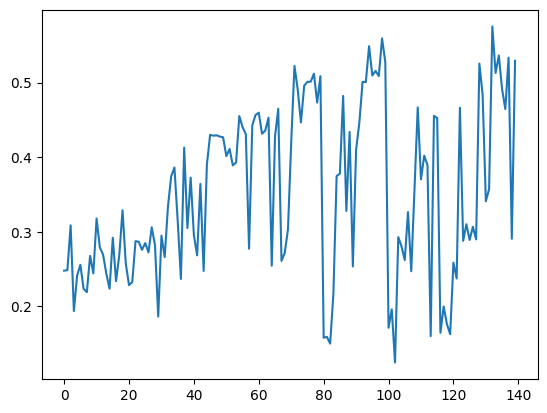

[PPO] Epoch 0: Loss=50.7262, Policy=0.0098, Value=101.5160
[PPO] Epoch 10: Loss=31.1679, Policy=-0.0061, Value=62.4277
[PPO] Epoch 20: Loss=24.4436, Policy=-0.0182, Value=49.0007
[PPO] Epoch 30: Loss=18.8349, Policy=-0.0138, Value=37.7900
Approx KL Learned: 0.07062332332134247
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 36/50 — steps: 4096


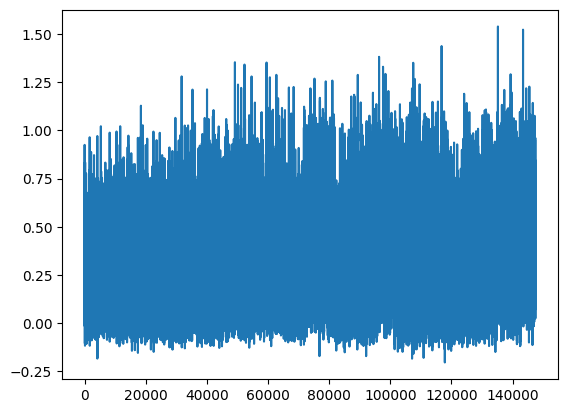

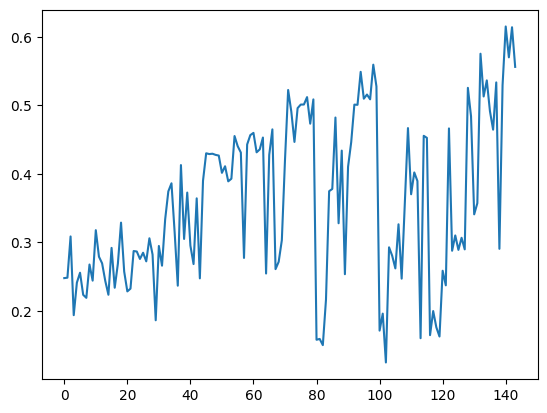

[PPO] Epoch 0: Loss=88.8590, Policy=0.0115, Value=177.8251
[PPO] Epoch 10: Loss=55.1242, Policy=0.0139, Value=110.3451
[PPO] Epoch 20: Loss=42.8313, Policy=-0.0091, Value=85.8099
[PPO] Epoch 30: Loss=35.4260, Policy=-0.0199, Value=71.0197
Approx KL Learned: 0.02995341457426548
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 37/50 — steps: 4096


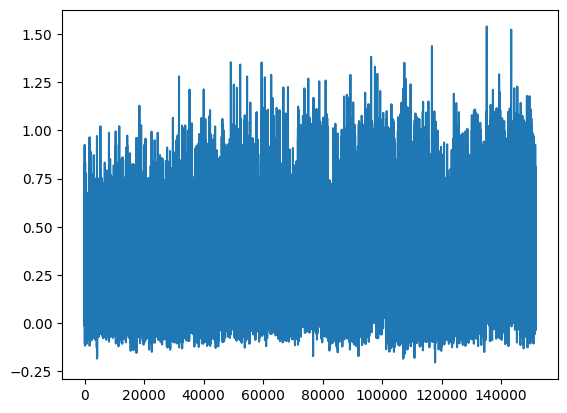

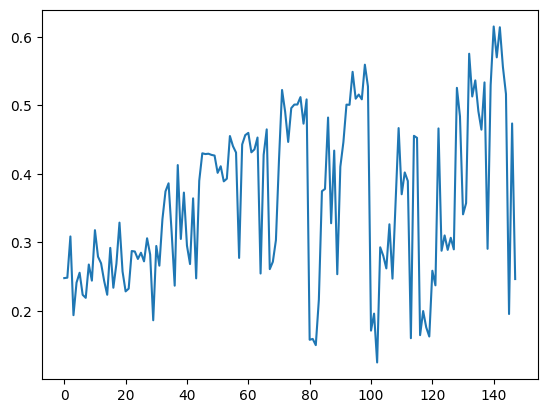

[PPO] Epoch 0: Loss=121.1304, Policy=0.0051, Value=242.3770
[PPO] Epoch 10: Loss=64.5832, Policy=-0.0008, Value=129.2917
[PPO] Epoch 20: Loss=53.5147, Policy=-0.0063, Value=107.1666
[PPO] Epoch 30: Loss=43.5209, Policy=-0.0108, Value=87.1889
Approx KL Learned: 0.031886205077171326
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 38/50 — steps: 4096


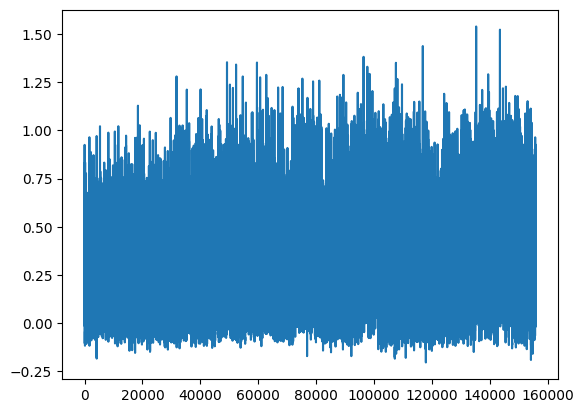

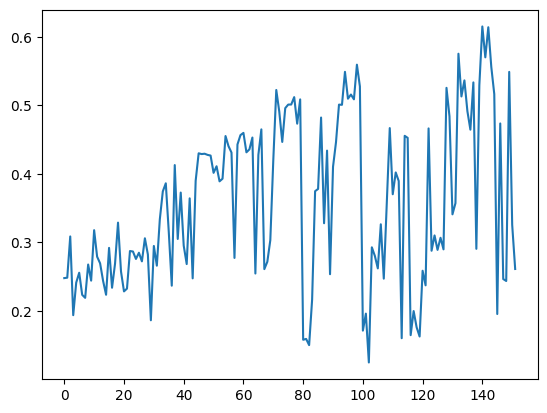

[PPO] Epoch 0: Loss=115.3015, Policy=0.0023, Value=230.7104
[PPO] Epoch 10: Loss=74.6769, Policy=0.0007, Value=149.4650
[PPO] Epoch 20: Loss=56.2174, Policy=-0.0088, Value=112.5683
[PPO] Epoch 30: Loss=45.5886, Policy=-0.0219, Value=91.3311
Approx KL Learned: 0.031002409756183624
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 39/50 — steps: 4096


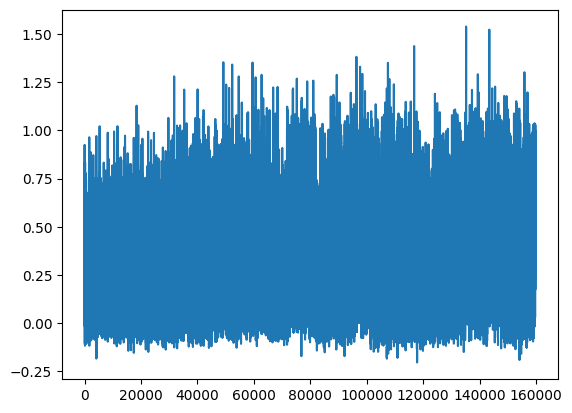

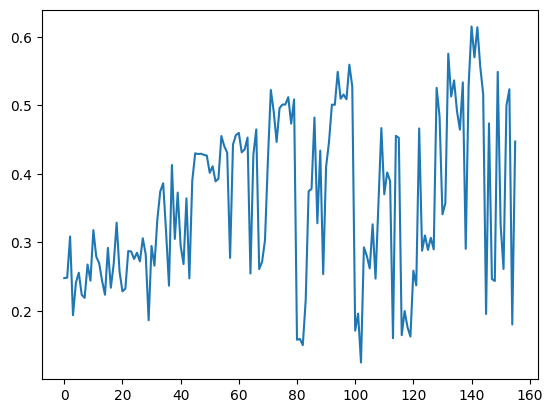

[PPO] Epoch 0: Loss=115.8609, Policy=0.0089, Value=231.8036
[PPO] Epoch 10: Loss=78.6658, Policy=0.0061, Value=157.4215
[PPO] Epoch 20: Loss=59.6720, Policy=-0.0045, Value=119.4537
[PPO] Epoch 30: Loss=47.3340, Policy=-0.0142, Value=94.7956
Approx KL Learned: 0.031320638954639435
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 40/50 — steps: 4096


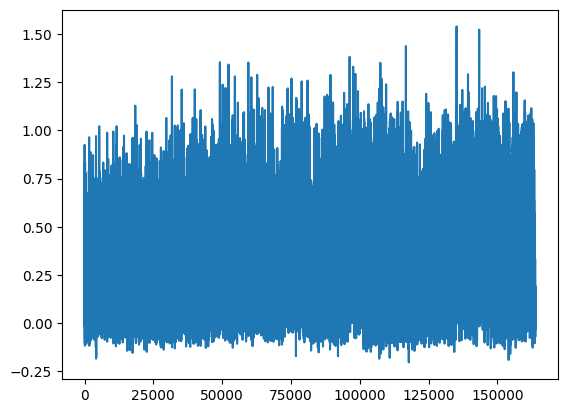

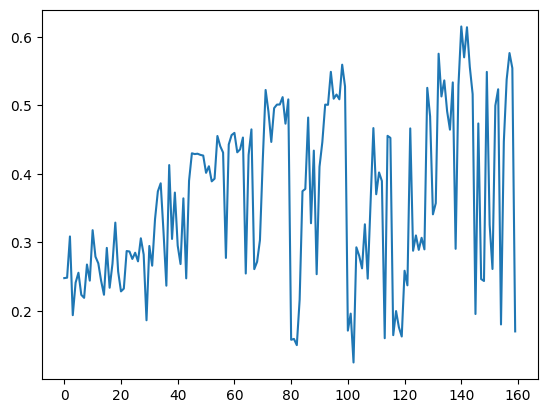

[PPO] Epoch 0: Loss=77.4524, Policy=0.0074, Value=154.9792
[PPO] Epoch 10: Loss=49.0538, Policy=0.0012, Value=98.1932
[PPO] Epoch 20: Loss=41.8883, Policy=-0.0129, Value=83.8911
[PPO] Epoch 30: Loss=35.6956, Policy=-0.0197, Value=71.5186
Approx KL Learned: 0.03986299782991409
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 41/50 — steps: 4096


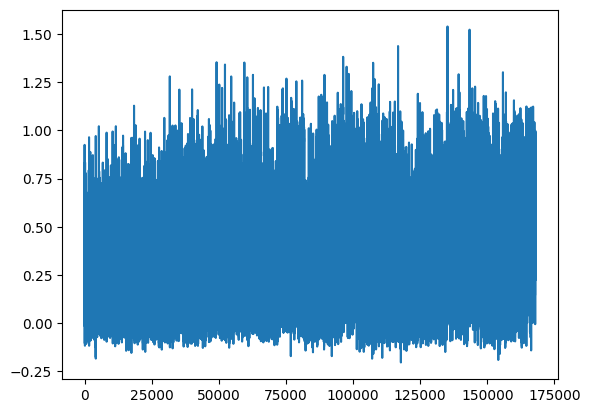

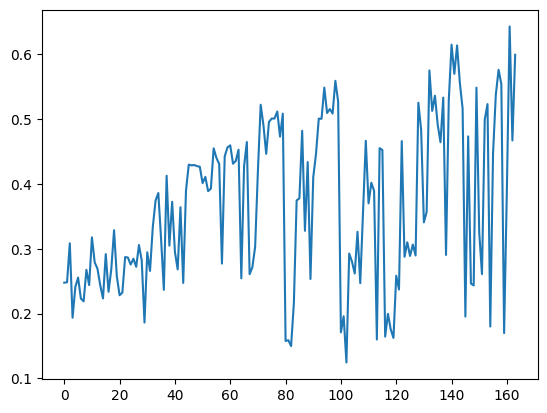

[PPO] Epoch 0: Loss=56.3753, Policy=0.0101, Value=112.7980
[PPO] Epoch 10: Loss=31.3362, Policy=0.0006, Value=62.7344
[PPO] Epoch 20: Loss=19.1712, Policy=-0.0076, Value=38.4226
[PPO] Epoch 30: Loss=13.4564, Policy=-0.0182, Value=27.0178
Approx KL Learned: 0.034230999648571014
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 42/50 — steps: 4096


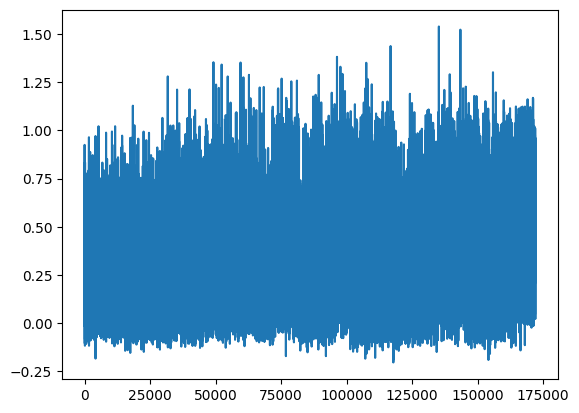

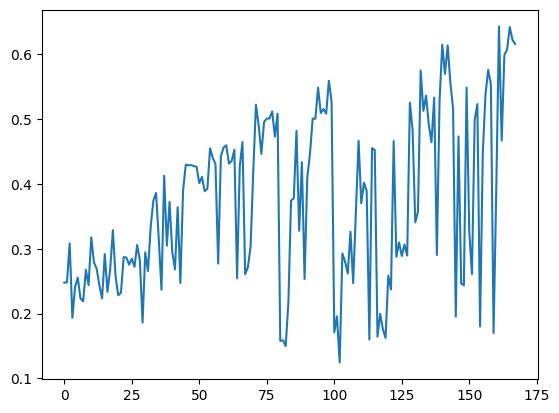

[PPO] Epoch 0: Loss=54.1304, Policy=0.0090, Value=108.3183
[PPO] Epoch 10: Loss=46.0455, Policy=-0.0015, Value=92.1693
[PPO] Epoch 20: Loss=38.1968, Policy=0.0010, Value=76.4755
[PPO] Epoch 30: Loss=32.1638, Policy=-0.0153, Value=64.4295
Approx KL Learned: 0.07499581575393677
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 43/50 — steps: 4096


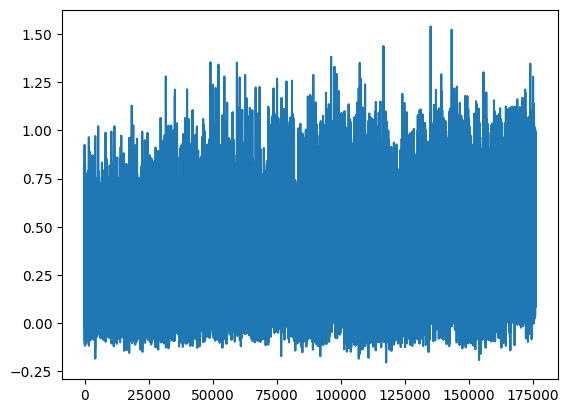

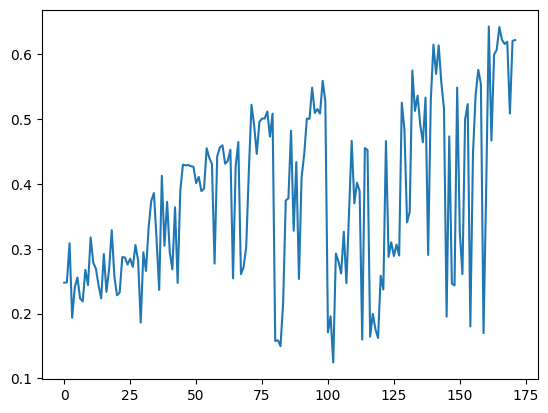

[PPO] Epoch 0: Loss=104.3461, Policy=0.0070, Value=208.8226
[PPO] Epoch 10: Loss=52.6252, Policy=0.0006, Value=105.3933
[PPO] Epoch 20: Loss=45.3078, Policy=-0.0159, Value=90.7903
[PPO] Epoch 30: Loss=36.4621, Policy=-0.0289, Value=73.1240
Approx KL Learned: 0.029898906126618385
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 44/50 — steps: 4096


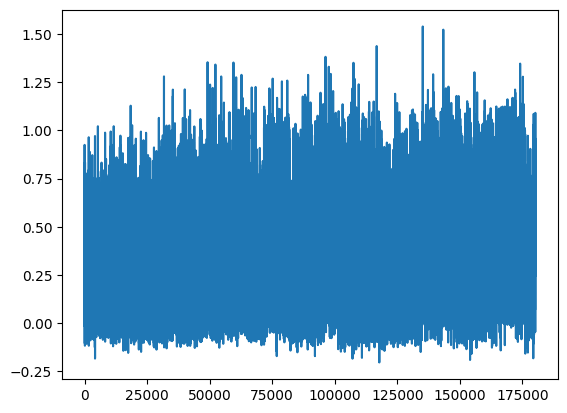

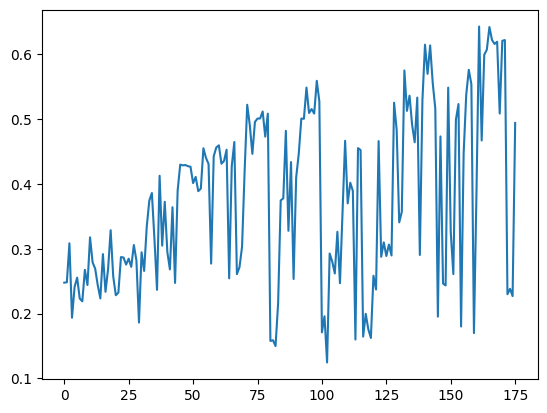

[PPO] Epoch 0: Loss=80.9999, Policy=0.0092, Value=162.0434
[PPO] Epoch 10: Loss=34.2471, Policy=0.0008, Value=68.5528
[PPO] Epoch 20: Loss=26.0716, Policy=-0.0086, Value=52.2293
[PPO] Epoch 30: Loss=20.7396, Policy=-0.0137, Value=41.5774
Approx KL Learned: 0.054840341210365295
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 45/50 — steps: 4096


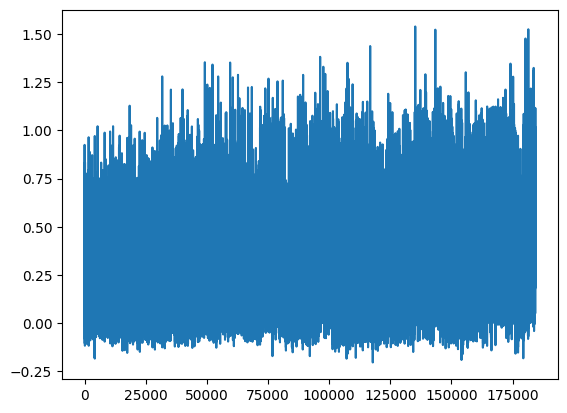

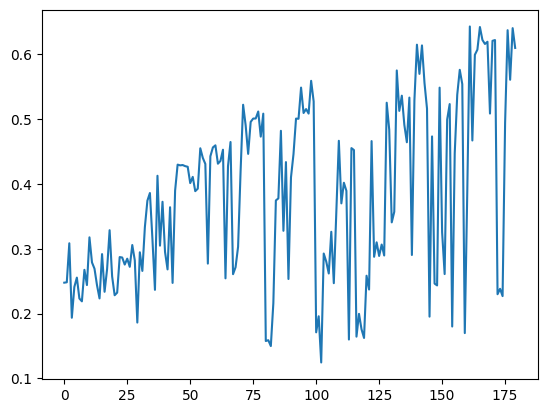

[PPO] Epoch 0: Loss=56.0877, Policy=0.0058, Value=112.2361
[PPO] Epoch 10: Loss=36.0378, Policy=0.0006, Value=72.1432
[PPO] Epoch 20: Loss=21.5259, Policy=-0.0126, Value=43.1481
[PPO] Epoch 30: Loss=22.5830, Policy=-0.0198, Value=45.2813
Approx KL Learned: 0.03579149767756462
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 46/50 — steps: 4096


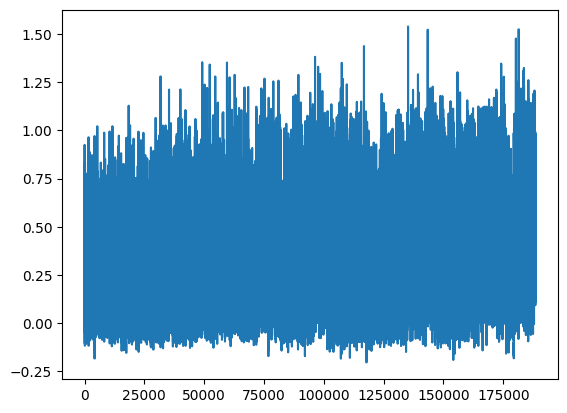

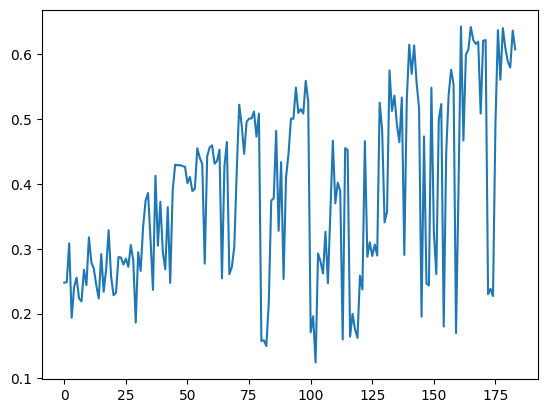

[PPO] Epoch 0: Loss=43.7100, Policy=0.0026, Value=87.4840
[PPO] Epoch 10: Loss=31.3283, Policy=-0.0088, Value=62.7354
[PPO] Epoch 20: Loss=21.0582, Policy=-0.0147, Value=42.2110
[PPO] Epoch 30: Loss=17.1570, Policy=-0.0205, Value=34.4232
Approx KL Learned: 0.12587586045265198
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 47/50 — steps: 4096


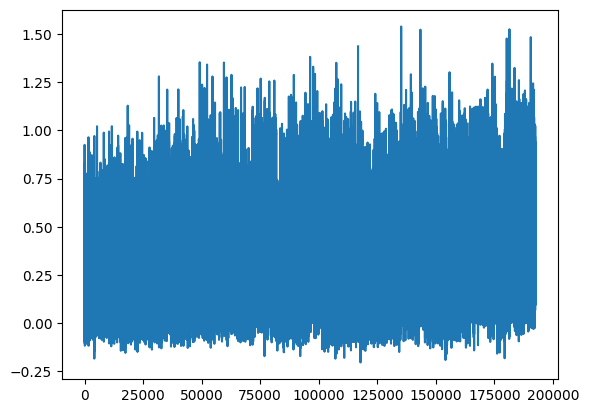

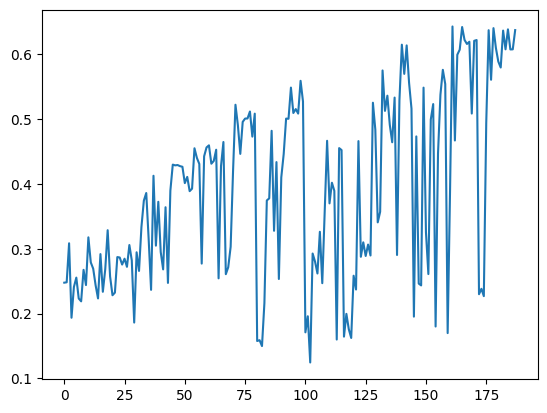

[PPO] Epoch 0: Loss=71.2692, Policy=0.0027, Value=142.6251
[PPO] Epoch 10: Loss=31.8426, Policy=0.0559, Value=63.6509
[PPO] Epoch 20: Loss=28.2224, Policy=0.0036, Value=56.5312
[PPO] Epoch 30: Loss=22.1606, Policy=-0.0129, Value=44.4302
Approx KL Learned: 0.03863256797194481
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 48/50 — steps: 4096


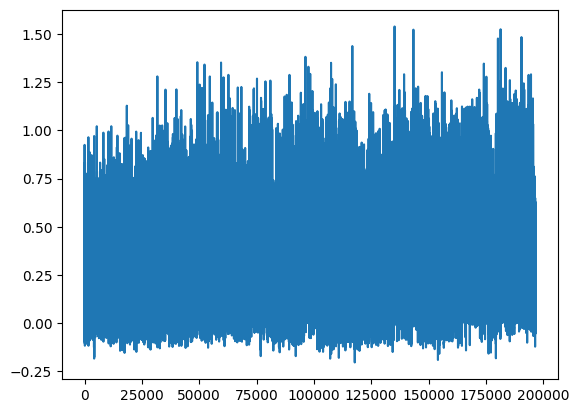

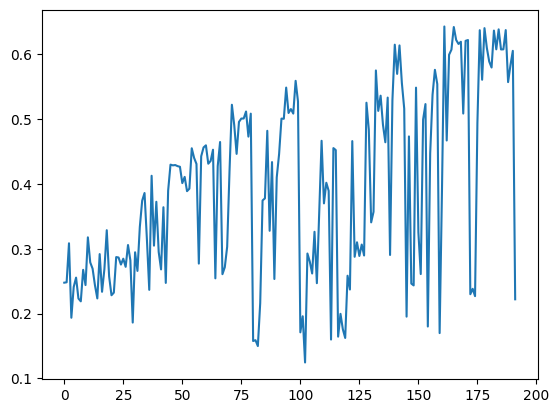

[PPO] Epoch 0: Loss=127.2047, Policy=0.0044, Value=254.5486
[PPO] Epoch 10: Loss=79.7033, Policy=-0.0038, Value=159.5598
[PPO] Epoch 20: Loss=61.5440, Policy=-0.0103, Value=123.2545
[PPO] Epoch 30: Loss=51.7191, Policy=-0.0197, Value=103.6239
Approx KL Learned: 0.023342415690422058
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 49/50 — steps: 4096


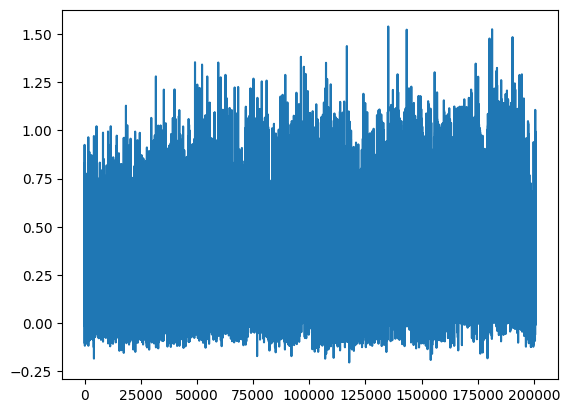

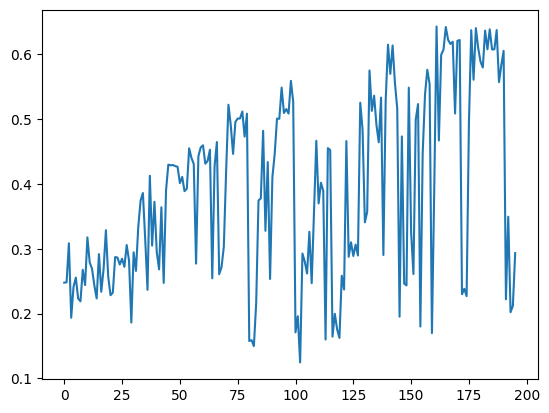

[PPO] Epoch 0: Loss=75.3280, Policy=0.0065, Value=150.6830
[PPO] Epoch 10: Loss=45.0111, Policy=-0.0017, Value=90.0675
[PPO] Epoch 20: Loss=16.4357, Policy=-0.0058, Value=32.9288
[PPO] Epoch 30: Loss=13.2144, Policy=-0.0149, Value=26.5096
Approx KL Learned: 0.04987526684999466
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 50/50 — steps: 4096


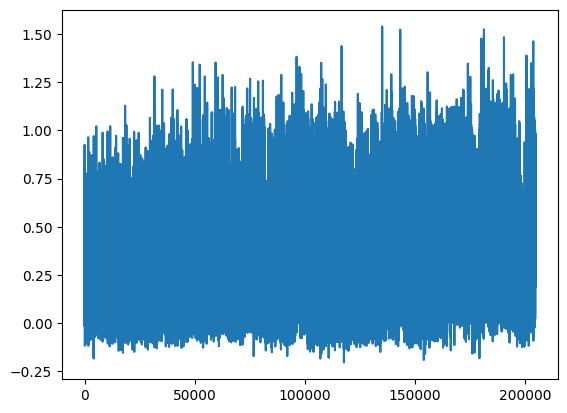

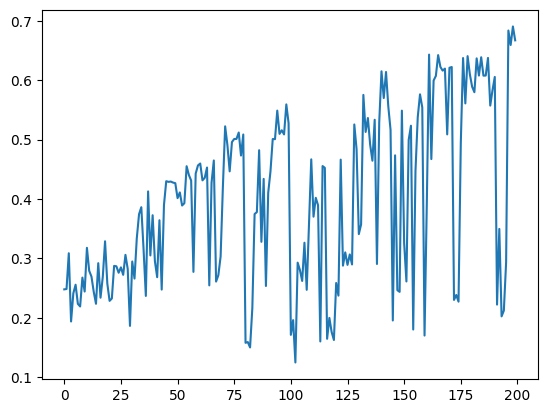

In [7]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 50)

[PPO] Epoch 0: Loss=91.1203, Policy=0.0040, Value=182.3472
[PPO] Epoch 10: Loss=37.2270, Policy=0.0024, Value=74.5612
[PPO] Epoch 20: Loss=24.8253, Policy=-0.0083, Value=49.7800
[PPO] Epoch 30: Loss=17.7802, Policy=-0.0180, Value=35.7077
Approx KL Learned: 0.024301566183567047
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 1/50 — steps: 4096


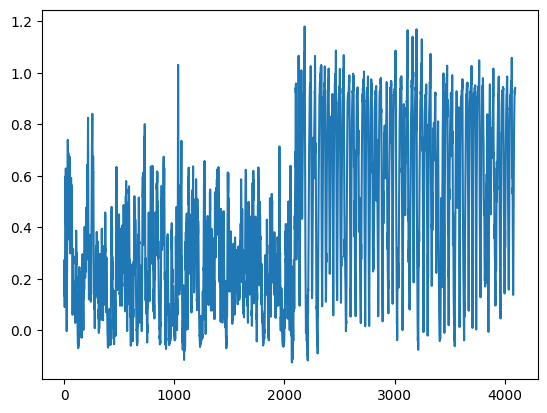

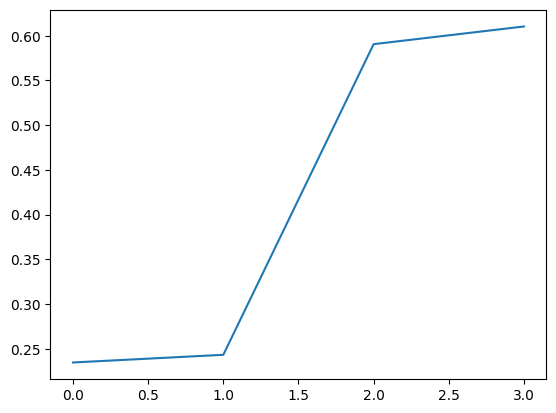

[PPO] Epoch 0: Loss=106.5043, Policy=0.0063, Value=213.0638
[PPO] Epoch 10: Loss=40.0155, Policy=0.0055, Value=80.0905
[PPO] Epoch 20: Loss=21.0185, Policy=-0.0065, Value=42.1198
[PPO] Epoch 30: Loss=17.0072, Policy=-0.0110, Value=34.1056
Approx KL Learned: 0.02886934205889702
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 2/50 — steps: 4096


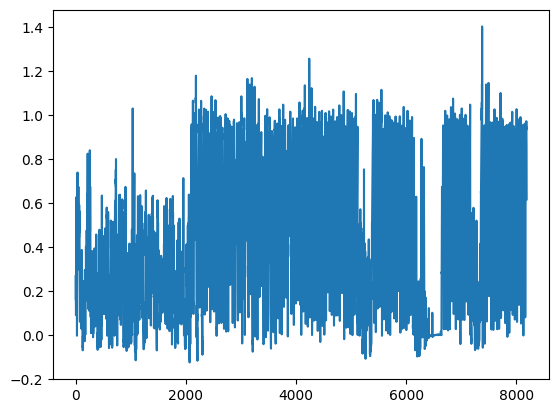

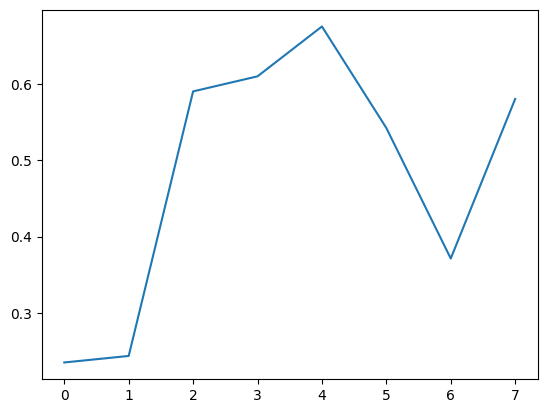

[PPO] Epoch 0: Loss=70.1673, Policy=0.0041, Value=140.3835
[PPO] Epoch 10: Loss=31.7971, Policy=-0.0016, Value=63.6456
[PPO] Epoch 20: Loss=25.2253, Policy=-0.0079, Value=50.5276
[PPO] Epoch 30: Loss=16.9832, Policy=-0.0166, Value=34.0637
Approx KL Learned: 0.046467266976833344
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 3/50 — steps: 4096


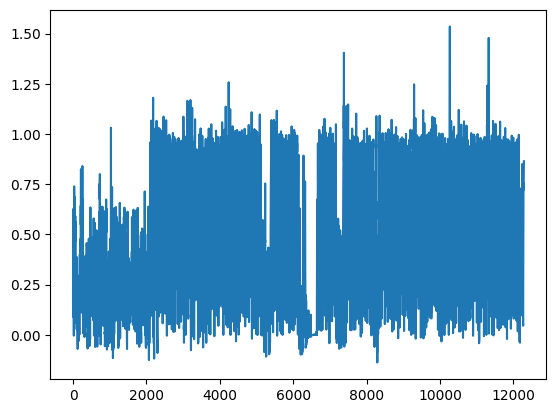

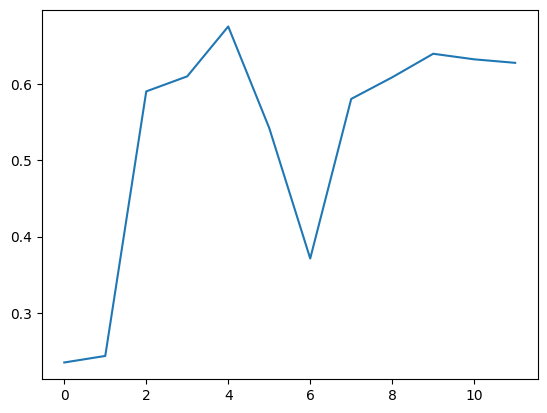

[PPO] Epoch 0: Loss=81.4294, Policy=0.0067, Value=162.9344
[PPO] Epoch 10: Loss=35.8327, Policy=0.0002, Value=71.7499
[PPO] Epoch 20: Loss=30.0526, Policy=-0.0084, Value=60.2079
[PPO] Epoch 30: Loss=25.5078, Policy=-0.0136, Value=51.1224
Approx KL Learned: 0.03487967327237129
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 4/50 — steps: 4096


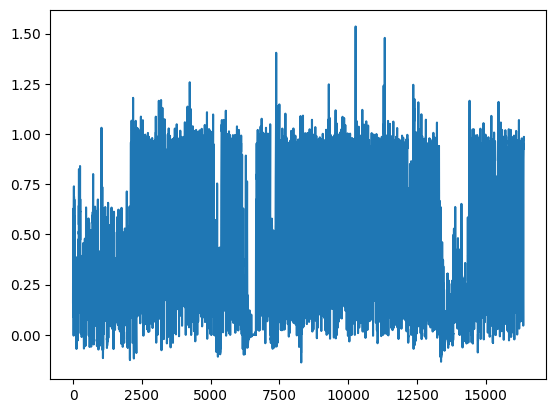

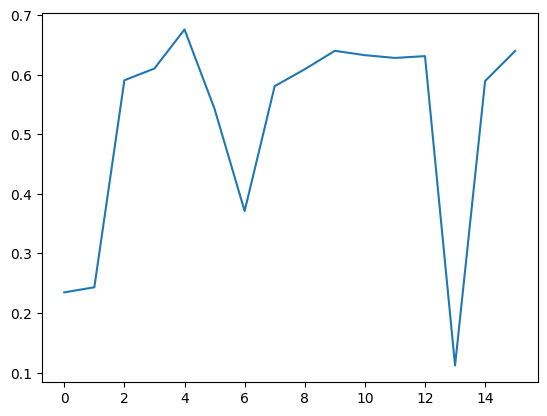

[PPO] Epoch 0: Loss=109.6573, Policy=0.0019, Value=219.4474
[PPO] Epoch 10: Loss=60.2229, Policy=-0.0033, Value=120.5873
[PPO] Epoch 20: Loss=52.1657, Policy=-0.0148, Value=104.4950
[PPO] Epoch 30: Loss=44.8834, Policy=-0.0238, Value=89.9480
Approx KL Learned: 0.025373846292495728
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 5/50 — steps: 4096


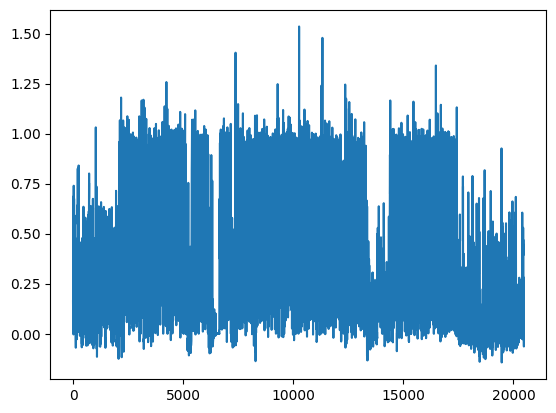

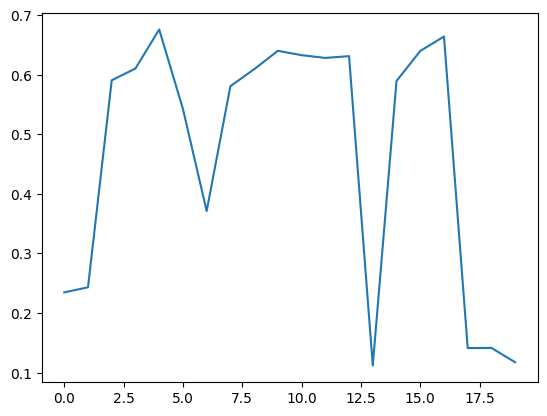

[PPO] Epoch 0: Loss=70.2221, Policy=0.0016, Value=140.5417
[PPO] Epoch 10: Loss=50.9626, Policy=-0.0035, Value=102.0326
[PPO] Epoch 20: Loss=40.1818, Policy=-0.0133, Value=80.4921
[PPO] Epoch 30: Loss=35.5533, Policy=-0.0218, Value=71.2531
Approx KL Learned: 0.04171666502952576
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 6/50 — steps: 4096


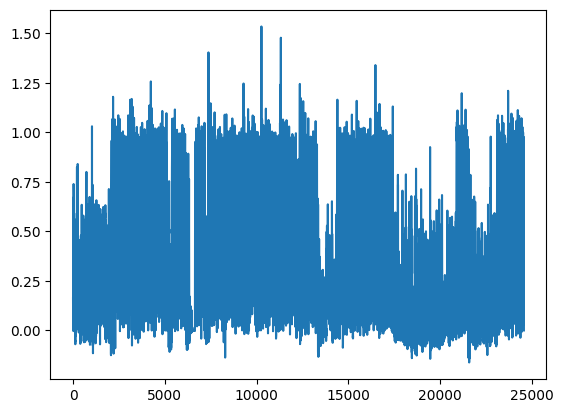

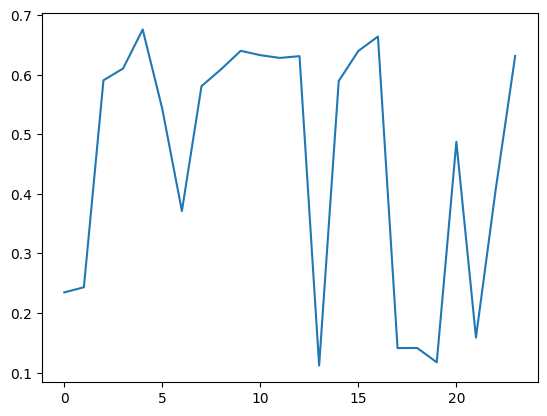

[PPO] Epoch 0: Loss=108.0060, Policy=0.0050, Value=216.0514
[PPO] Epoch 10: Loss=85.5582, Policy=0.0015, Value=171.1715
[PPO] Epoch 20: Loss=26.7374, Policy=-0.0053, Value=53.5432
[PPO] Epoch 30: Loss=21.1721, Policy=-0.0137, Value=42.4377
Approx KL Learned: 0.06087808683514595
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 7/50 — steps: 4096


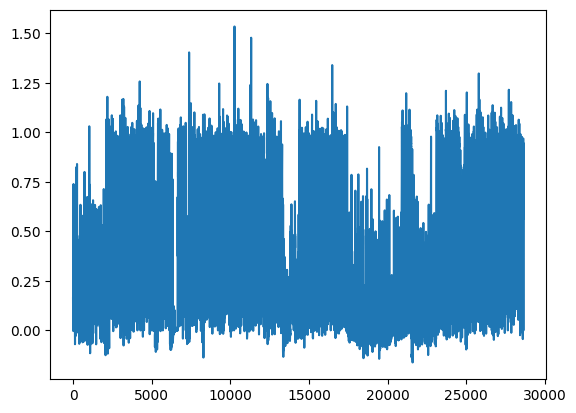

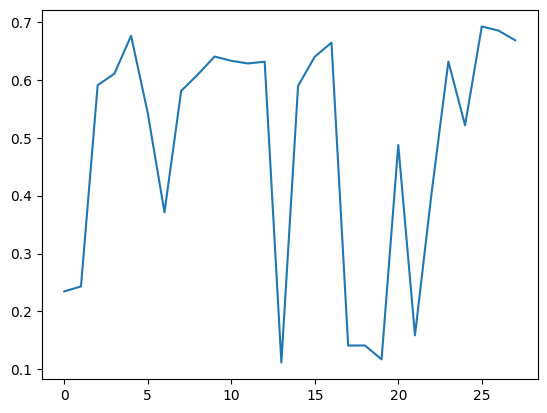

[PPO] Epoch 0: Loss=97.9628, Policy=0.0088, Value=196.0256
[PPO] Epoch 10: Loss=58.3171, Policy=0.0003, Value=116.7475
[PPO] Epoch 20: Loss=41.5604, Policy=-0.0173, Value=83.2693
[PPO] Epoch 30: Loss=34.1020, Policy=-0.0285, Value=68.3744
Approx KL Learned: 0.04262330383062363
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 8/50 — steps: 4096


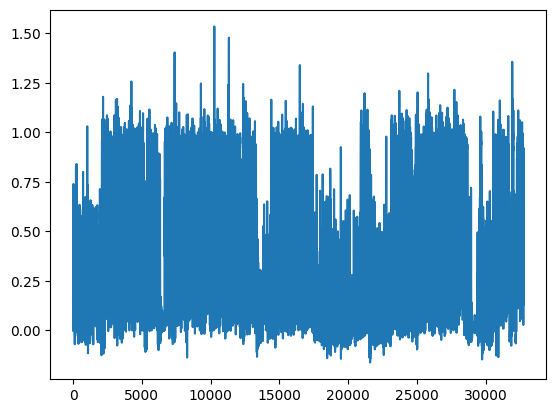

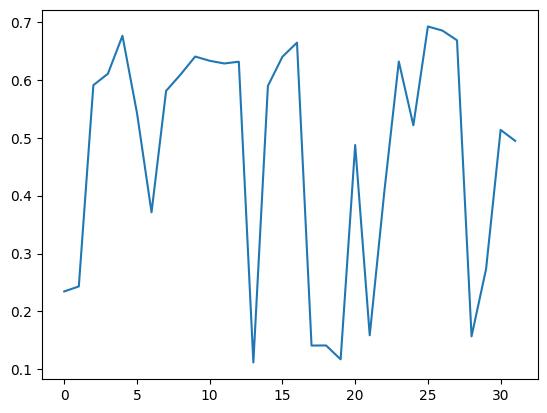

[PPO] Epoch 0: Loss=84.0293, Policy=0.0088, Value=168.1726
[PPO] Epoch 10: Loss=58.3878, Policy=-0.0062, Value=116.9173
[PPO] Epoch 20: Loss=48.7360, Policy=-0.0170, Value=97.6354
[PPO] Epoch 30: Loss=42.2260, Policy=-0.0264, Value=84.6344
Approx KL Learned: 0.028892774134874344
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 9/50 — steps: 4096


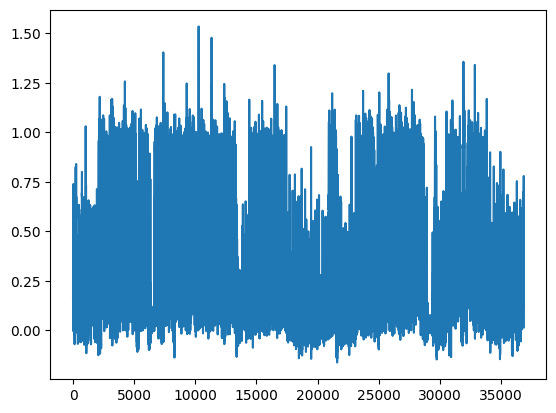

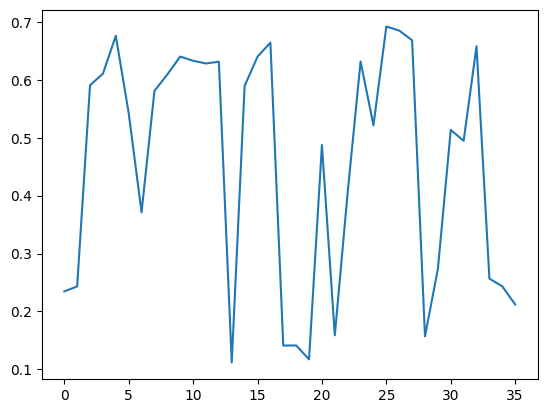

[PPO] Epoch 0: Loss=146.1638, Policy=0.0038, Value=292.4702
[PPO] Epoch 10: Loss=110.1635, Policy=-0.0038, Value=220.4827
[PPO] Epoch 20: Loss=80.0368, Policy=-0.0088, Value=160.2407
[PPO] Epoch 30: Loss=66.3505, Policy=-0.0166, Value=132.8832
Approx KL Learned: 0.021203789860010147
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 10/50 — steps: 4096


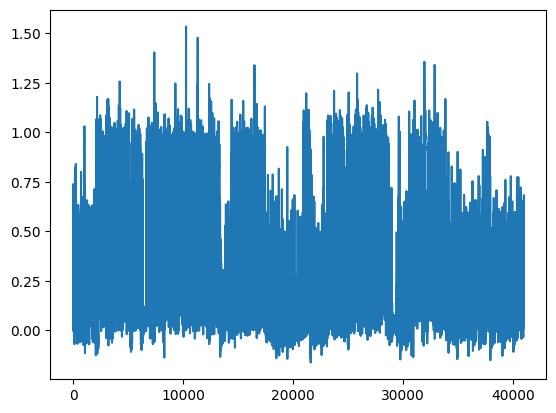

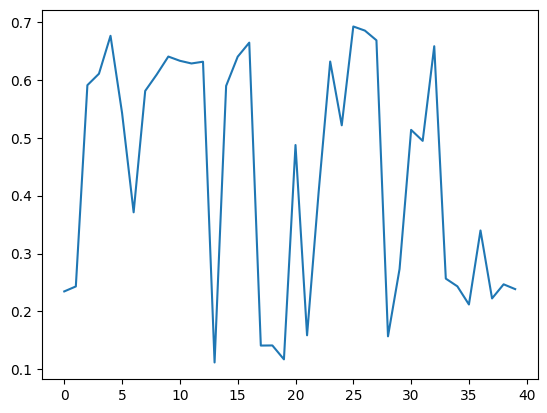

[PPO] Epoch 0: Loss=78.7821, Policy=0.0046, Value=157.6278
[PPO] Epoch 10: Loss=49.8537, Policy=-0.0027, Value=99.7843
[PPO] Epoch 20: Loss=32.7707, Policy=-0.0092, Value=65.6358
[PPO] Epoch 30: Loss=29.0150, Policy=-0.0180, Value=58.1430
Approx KL Learned: 0.051062554121017456
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training.pt
Update 11/50 — steps: 4096


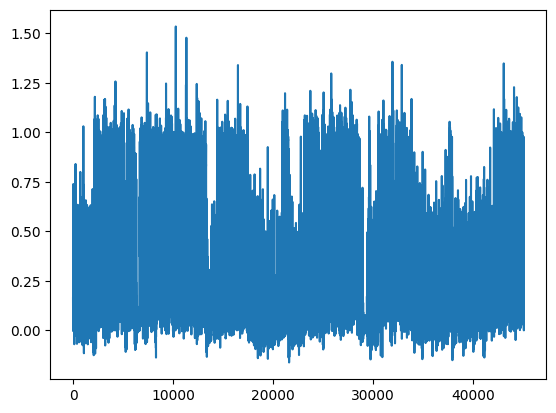

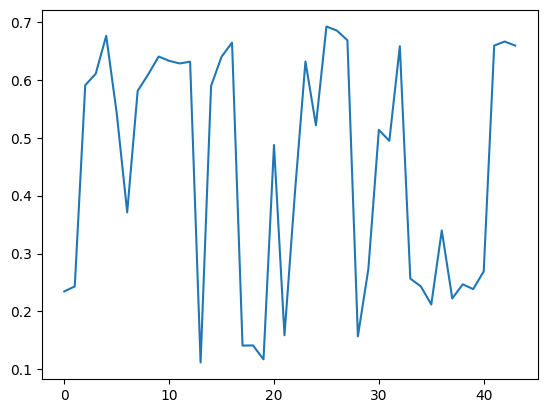

KeyboardInterrupt: 

In [19]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training.pt", ppo, clip_env, clip_actor_critic, 50)

In [28]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=512
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic)

[🎞️] Saved video to rollout.mp4


[[5.605288982391357, 5.026923179626465],
 [5.605288982391357, 5.276923179626465],
 [5.605288982391357, 5.276923179626465],
 [5.605288982391357, 5.276923179626465],
 [5.605288982391357, 5.526923179626465],
 [5.605288982391357, 5.776923179626465],
 [5.605288982391357, 5.776923179626465],
 [5.480288982391357, 5.993429660797119],
 [5.480288982391357, 5.993429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 6.118429660797119],
 [5.263782501220703, 5.868429660797119],
 [5.263782501220

In [34]:
!pip install imageio imageio-ffmpeg

In [9]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [10]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.84921875
Rand: 0.790966796875
Policy: 0.867724609375
Rand: 0.836279296875
Policy: 0.835107421875
Rand: 0.752294921875
Policy: 0.83193359375
Rand: 0.7958984375
Policy: 0.868505859375
Rand: 0.871484375


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

In [20]:
controller.stop()